In [1]:
# import statements
%load_ext autoreload
%autoreload 2
%cd "../../"

import torch 
from torch.autograd import Variable 
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    

import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/m/home/home5/56/kapoorj1/unix/repos/bayesian-ode


In [152]:

# def closure(add_prior=True):
#     return 0.5*(0.2*x*x + (2*y+1.0*x*x)**2)

# def prob(x, y):
#     return np.exp(-0.5*(0.2*x*x + (2*y+ 1.0*x*x)**2))



def get_multimodal_fns(x,y, mixture=(0.5,0.5), means=([-1,-1], [1,1]),
                       sigmas=([1,0.5], [0.5,1]), corr=(0.5,-0.5)):


    def prob_multimodal(x__, y__):
        prob = 0.
        for i, w in enumerate(mixture):    
            x_ = (x__ - means[i][0])/sigmas[i][0]
            y_ = (y__ - means[i][1])/sigmas[i][1]
            if 'torch' in type(x__).__module__:
                prob += w*torch.exp(-(x_**2 + y_**2 - 2*corr[i]*x_*y_)/(2*(1-corr[i]**2)))/(sigmas[i][0]*sigmas[i][1]*np.sqrt(1-corr[i]**2))    
            elif 'numpy' in type(x__).__module__:
                prob += w*np.exp(-(x_**2 + y_**2 - 2*corr[i]*x_*y_)/(2*(1-corr[i]**2)))/(sigmas[i][0]*sigmas[i][1]*np.sqrt(1-corr[i]**2))        
        return prob

    def closure_multimodal(add_prior=True):
        return -torch.log(prob_multimodal(x, y))


    def plot_contours_multimodal(ax):
        
        X = np.linspace(-2*max([sigmas[i][0] for i in range(len(sigmas))]) + min([means[i][0] for i in range(len(means))]),
                        2*max([sigmas[i][0] for i in range(len(sigmas))]) + max([means[i][0] for i in range(len(means))]), 1000)
        Y = np.linspace(-2*max([sigmas[i][1] for i in range(len(sigmas))]) + min([means[i][1] for i in range(len(means))]),
                        2*max([sigmas[i][1] for i in range(len(sigmas))]) + max([means[i][1] for i in range(len(means))]), 1000)

        X, Y = np.meshgrid(X, Y)

        Z = prob_multimodal(X, Y)
        cmap = cm.get_cmap('binary')
        cmap.set_under(color='w')
        ax.contourf(X, Y, Z, cmap=cmap, alpha=0.5, extend='both')
#         ax.scatter([mean[0] for mean in means], [mean[1] for mean in means], color='g', s=3)
        
       
    def plot_density_multimodal(ax, x_, y_):

        ax.set_xlim(-2*max([sigmas[i][0] for i in range(len(sigmas))]) + min([means[i][0] for i in range(len(means))]),
                        2*max([sigmas[i][0] for i in range(len(sigmas))]) + max([means[i][0] for i in range(len(means))]))
        ax.set_ylim(-2*max([sigmas[i][1] for i in range(len(sigmas))]) + min([means[i][1] for i in range(len(means))]),
                        2*max([sigmas[i][1] for i in range(len(sigmas))]) + max([means[i][1] for i in range(len(means))]))
                        
        sns.kdeplot(x_, y_, shade=True, ax=ax, cmap='binary', n_levels = 10, rasterized=True, shade_lowest=False, alpha=0.5)

    return closure_multimodal, prob_multimodal, plot_contours_multimodal, plot_density_multimodal


def get_gauss_fns(x, y, sigma1, sigma2, corr):

    def closure_gauss(add_prior=True):
        x_ = (x-2)/sigma1
        y_ = (y-4)/sigma2
        return (x_**2 + y_**2 - 2*corr*x_*y_)/(2*(1-corr**2))    
    
    def prob_gauss(x__,y__):
        x_ = (x__-2)/sigma1
        y_ = (y__-4)/sigma2
        return np.exp(-(x_**2 + y_**2 - 2*corr*x_*y_)/(2*(1-corr**2)))    

    def plot_contours_gauss(ax):    
        X = np.linspace(-max(sigma1*2,2)+2, max(2,sigma1*2)+2, 1000)
        Y = np.linspace(-max(2,sigma2*2)+4, max(2,sigma2*2)+4, 1000)
        
        X, Y = np.meshgrid(X, Y)

        Z = prob_gauss(X, Y)
        cmap = cm.get_cmap('binary')
        cmap.set_under(color='w')
        # ax.set_clim(vmin=np.min(Z), vmax=np.max(Z))
        ax.contourf(X, Y, Z, cmap=cmap, alpha=0.5, extend='both')
        
    def plot_density_gauss(ax, x_, y_):

        ax.set_xlim(-max(sigma1*2,2)+2, max(2,sigma1*2)+2)
        ax.set_ylim(-max(2,sigma2*2)+4, max(2,sigma2*2)+4)
                        
        sns.kdeplot(x_, y_, shade=True, ax=ax, cmap='binary', rasterized=True, shade_lowest=False, alpha=0.5)

    
    return closure_gauss, prob_gauss, plot_contours_gauss, plot_density_gauss

x = torch.nn.Parameter(torch.randn([1]))
y = torch.nn.Parameter(torch.randn([1]))

# closure, prob, plot_contours, plot_density = get_multimodal_fns(x, y, mixture=[1./25.]*25,
#                                                  means=[[2.*(i+1)-5., 2.*(j+1)-5.] for i in range(5) for j in range(5)],
#                                                  sigmas=[[0.5,0.5] for i in range(25)],
#                                                  corr = [0.]*25)

# def closure(add_prior=True):
#     return 0.5*(0.03*(x-2)**2 + 1*(y-4)**2)

# def prob(x, y):
#     return 0.5*(0.03*(x-2)**2 + 1*(y-4)**2)

# def closure(add_prior=True):
#     return 0.5*(1*(x-2)**2 + 1*(y-4)**2)

# def prob(x, y):
#     return 0.5*(1*(x-2)**2 + 1*(y-4)**2)

# def plot_contours(ax):
#     X = np.linspace(-6, 6, 1000)
#     Y = np.linspace(-10, 2, 3000)
#     X, Y = np.meshgrid(X, Y)

#     Z = prob(X, Y)
#     my_cmap = cm.get_cmap("binary")
#     my_cmap.set_over('k')
#     my_cmap.set_under('w')
#     sns.set(context="notebook", style="whitegrid",
#         rc={"axes.axisbelow": False,"axes.grid": False})
#     ax.contourf(X,Y,Z,cmap=my_cmap,vmin=0.01,vmax=0.99, alpha=0.5, extend='both')
# #     ax.contour(X, Y, Z, zorder=-10)

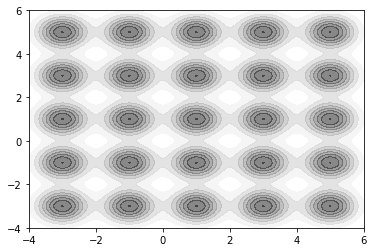

In [16]:
fig, ax = plt.subplots()
plot_contours(ax)

In [19]:

from samplers.metrics import *


def hess_closure():
    hess = eval_full_hessian(torch.autograd.grad(closure(), params, create_graph=True), params)
#     plt.figure()
#     plt.imshow(hess.clone().detach().numpy())
#     plt.colorbar()
    return hess

# metric = SoftAbsMetric(closure=hess_closure, softabs_coeff=10)
# metric = HessianMetric(closure=hess_closure)
# metric = IdentityMetric(size=l)

In [165]:
x = torch.nn.Parameter(torch.randn([1]))
y = torch.nn.Parameter(torch.randn([1]))

params = [x, y]


# closure, prob, plot_contours, plot_density = get_gauss_fns(x, y, 3.,0.3,.7)

n = 5
closure, prob, plot_contours, plot_density = get_multimodal_fns(x, y, mixture=[1./(n**2)]*(n**2),
                                                 means=[[2.*(i+1)-n, 2.*(j+1)-n] for i in range(n) for j in range(n)],
                                                 sigmas=[[0.5,0.5] for i in range(n**2)],
                                                 corr = [0.]*(n**2))

from samplers.langevin import MALA, MMALA, SGLD, pSGLD, HAMCMC, HAMCMC2, HAMCMC3, HAMCMC4, cSGLD
from samplers.hamiltonian import aSGHMC, acSGHMC

# sampler = MALA(params, lr=5e-2, add_noise=True)
# chain, logp_array = sampler.sample(closure, burn_in=2000, num_samples=10000, print_loss=True)

# sampler = SGLD(params, lr0=0.3, lr_gamma=0.51, lr_t0=10, lr_alpha=0.01, lambda_=1e-5, alpha=0.95,)
# chain, logp_array = sampler.sample(closure, burn_in=2000, num_samples=10000, print_loss=True)

# sampler = pSGLD(params, lr0=0.1, lr_gamma=0.51, lr_t0=10, lr_alpha=0.01, lambda_=1e-8, alpha=0.98,)
# chain, logp_array = sampler.sample(closure, burn_in=200, num_samples=1000, print_loss=True)

# sampler = HAMCMC(params, lr0=0.03, lr_gamma=0.51, lr_t0=1, lr_alpha=0.01, trust_reg=0, memory=1, H_gamma=1e-0, cholesky_factor=1e-1)
# chain, logp_array = sampler.sample(closure, burn_in=2000, num_samples=10000, print_loss=True, use_old_lbfgs=True, add_noise=False)

# sampler = HAMCMC2(params, lr0=0.01, lr_gamma=0.51, lr_t0=100, lr_alpha=0.1, trust_reg=1e0, memory=3, H_gamma=1e0, cholesky_factor=1e-1)
# chain, logp_array = sampler.sample(closure, burn_in=2000, num_samples=10000, print_loss=True, use_old_lbfgs=True, add_noise=False)

# sampler = HAMCMC3(params, lr0=0.001, lr_gamma=0.51, lr_t0=100, lr_alpha=0.1, trust_reg=1e0, memory=3, H_gamma=1e0, cholesky_factor=1e-1)
# chain, logp_array = sampler.sample(closure, burn_in=200, num_samples=1000, print_loss=True, use_old_lbfgs=True, add_noise=False)

# sampler = HAMCMC4(params, lr0=0.01, lr_gamma=0.51, lr_t0=100, lr_alpha=0.1, trust_reg=1e1, memory=3, H_gamma=1e-2, cholesky_factor=1e-1)
# chain, logp_array = sampler.sample(closure, burn_in=2000, num_samples=10000, print_loss=True, use_old_lbfgs=False, add_noise=True)

# sampler = aSGHMC(params, lr=0.1, add_noise=True, mom_decay=5e-2, lambda_=1e-8)
# chain, logp_array = sampler.sample(closure, burn_in=2000, num_samples=10000, print_loss=True, resample_mom_every=100000)

sampler = acSGHMC(params, lr0=0.05, M=30, beta=0.1, mom_decay=5e-2, lambda_=1e-8)
chain = sampler.sample(closure, burn_in=200, num_samples=30000, print_iters=True, print_loss=True)

# sampler = cSGLD(params, lr0=0.05, M=30, beta=0.1)
# chain = sampler.sample(closure, burn_in = 200, num_samples = 30000, print_iters=True, print_loss=True)


<class 'dict'>
Burn-in phase started
Burn-in iter 0001 | loss 2.542132
Burn-in iter 0002 | loss 2.533673
Burn-in iter 0003 | loss 2.517640
Burn-in iter 0004 | loss 2.494842
Burn-in iter 0005 | loss 2.466078
Burn-in iter 0006 | loss 2.432156
Burn-in iter 0007 | loss 2.393897
Burn-in iter 0008 | loss 2.352133
Burn-in iter 0009 | loss 2.307717
Burn-in iter 0010 | loss 2.261511
Burn-in iter 0011 | loss 2.214386
Burn-in iter 0012 | loss 2.167211
Burn-in iter 0013 | loss 2.120846
Burn-in iter 0014 | loss 2.076131
Burn-in iter 0015 | loss 2.033875
Burn-in iter 0016 | loss 1.994845
Burn-in iter 0017 | loss 1.959750
Burn-in iter 0018 | loss 1.929219
Burn-in iter 0019 | loss 1.903753
Burn-in iter 0020 | loss 1.883620
Burn-in iter 0021 | loss 1.868650
Burn-in iter 0022 | loss 1.858208
Burn-in iter 0023 | loss 1.851566
Burn-in iter 0024 | loss 1.848145
Burn-in iter 0025 | loss 1.847531
Burn-in iter 0026 | loss 1.849338
Burn-in iter 0027 | loss 1.852916
Burn-in iter 0028 | loss 1.857244
Burn-in ite

Sample iter 0042 | loss 3.404409
Sample iter 0043 | loss 3.409592
Sample iter 0044 | loss 3.424608
Sample iter 0045 | loss 3.443364
Sample iter 0046 | loss 3.462263
Sample iter 0047 | loss 3.480618
Sample iter 0048 | loss 3.506956
Sample iter 0049 | loss 3.509353
Sample iter 0050 | loss 3.496930
Sample iter 0051 | loss 3.454156
Sample iter 0052 | loss 3.395703
Sample iter 0053 | loss 3.326594
Sample iter 0054 | loss 3.229708
Sample iter 0055 | loss 3.136113
Sample iter 0056 | loss 3.017188
Sample iter 0057 | loss 2.911643
Sample iter 0058 | loss 2.844918
Sample iter 0059 | loss 2.804343
Sample iter 0060 | loss 2.769974
Sample iter 0061 | loss 2.701551
Sample iter 0062 | loss 2.637136
Sample iter 0063 | loss 2.611576
Sample iter 0064 | loss 2.589756
Sample iter 0065 | loss 2.552180
Sample iter 0066 | loss 2.508026
Sample iter 0067 | loss 2.459506
Sample iter 0068 | loss 2.410066
Sample iter 0069 | loss 2.338024
Sample iter 0070 | loss 2.266375
Sample iter 0071 | loss 2.232208
Sample ite

Sample iter 0296 | loss 2.559606
Sample iter 0297 | loss 2.573775
Sample iter 0298 | loss 2.591680
Sample iter 0299 | loss 2.609083
Sample iter 0300 | loss 2.643355
Sample iter 0301 | loss 2.671464
Sample iter 0302 | loss 2.688690
Sample iter 0303 | loss 2.694237
Sample iter 0304 | loss 2.685857
Sample iter 0305 | loss 2.663327
Sample iter 0306 | loss 2.654344
Sample iter 0307 | loss 2.653944
Sample iter 0308 | loss 2.658654
Sample iter 0309 | loss 2.648718
Sample iter 0310 | loss 2.664486
Sample iter 0311 | loss 2.686908
Sample iter 0312 | loss 2.698296
Sample iter 0313 | loss 2.689097
Sample iter 0314 | loss 2.673789
Sample iter 0315 | loss 2.669472
Sample iter 0316 | loss 2.673222
Sample iter 0317 | loss 2.666864
Sample iter 0318 | loss 2.682273
Sample iter 0319 | loss 2.716348
Sample iter 0320 | loss 2.747738
Sample iter 0321 | loss 2.799074
Sample iter 0322 | loss 2.825139
Sample iter 0323 | loss 2.851302
Sample iter 0324 | loss 2.893685
Sample iter 0325 | loss 2.935271
Sample ite

Sample iter 0548 | loss 3.153511
Sample iter 0549 | loss 3.153456
Sample iter 0550 | loss 3.148811
Sample iter 0551 | loss 3.147492
Sample iter 0552 | loss 3.145004
Sample iter 0553 | loss 3.146533
Sample iter 0554 | loss 3.144503
Sample iter 0555 | loss 3.147557
Sample iter 0556 | loss 3.147817
Sample iter 0557 | loss 3.148465
Sample iter 0558 | loss 3.145909
Sample iter 0559 | loss 3.142545
Sample iter 0560 | loss 3.140044
Sample iter 0561 | loss 3.139111
Sample iter 0562 | loss 3.137019
Sample iter 0563 | loss 3.135655
Sample iter 0564 | loss 3.133865
Sample iter 0565 | loss 3.130614
Sample iter 0566 | loss 3.128752
Sample iter 0567 | loss 3.128592
Sample iter 0568 | loss 3.125826
Sample iter 0569 | loss 3.127393
Sample iter 0570 | loss 3.128578
Sample iter 0571 | loss 3.130683
Sample iter 0572 | loss 3.134032
Sample iter 0573 | loss 3.137968
Sample iter 0574 | loss 3.139731
Sample iter 0575 | loss 3.140516
Sample iter 0576 | loss 3.140623
Sample iter 0577 | loss 3.140965
Sample ite

Sample iter 0810 | loss 2.728991
Sample iter 0811 | loss 2.700772
Sample iter 0812 | loss 2.664039
Sample iter 0813 | loss 2.619364
Sample iter 0814 | loss 2.567535
Sample iter 0815 | loss 2.509598
Sample iter 0816 | loss 2.446857
Sample iter 0817 | loss 2.380836
Sample iter 0818 | loss 2.313204
Sample iter 0819 | loss 2.245679
Sample iter 0820 | loss 2.179938
Sample iter 0821 | loss 2.117522
Sample iter 0822 | loss 2.059771
Sample iter 0823 | loss 2.007779
Sample iter 0824 | loss 1.962361
Sample iter 0825 | loss 1.924047
Sample iter 0826 | loss 1.893090
Sample iter 0827 | loss 1.869483
Sample iter 0828 | loss 1.852981
Sample iter 0829 | loss 1.843138
Sample iter 0830 | loss 1.839341
Sample iter 0831 | loss 1.840846
Sample iter 0832 | loss 1.846819
Sample iter 0833 | loss 1.856370
Sample iter 0834 | loss 1.868594
Sample iter 0835 | loss 1.882597
Sample iter 0836 | loss 1.897528
Sample iter 0837 | loss 1.912604
Sample iter 0838 | loss 1.927128
Sample iter 0839 | loss 1.940500
Sample ite

Sample iter 1066 | loss 1.861873
Sample iter 1067 | loss 1.844249
Sample iter 1068 | loss 1.843692
Sample iter 1069 | loss 1.850051
Sample iter 1070 | loss 1.864402
Sample iter 1071 | loss 1.885515
Sample iter 1072 | loss 1.915607
Sample iter 1073 | loss 1.948689
Sample iter 1074 | loss 1.978736
Sample iter 1075 | loss 1.994545
Sample iter 1076 | loss 2.011114
Sample iter 1077 | loss 2.032460
Sample iter 1078 | loss 2.056153
Sample iter 1079 | loss 2.092751
Sample iter 1080 | loss 2.111830
Sample iter 1081 | loss 2.146178
Sample iter 1082 | loss 2.188850
Sample iter 1083 | loss 2.224358
Sample iter 1084 | loss 2.274506
Sample iter 1085 | loss 2.319774
Sample iter 1086 | loss 2.364602
Sample iter 1087 | loss 2.402288
Sample iter 1088 | loss 2.465028
Sample iter 1089 | loss 2.534020
Sample iter 1090 | loss 2.583306
Sample iter 1091 | loss 2.651835
Sample iter 1092 | loss 2.702230
Sample iter 1093 | loss 2.723587
Sample iter 1094 | loss 2.785787
Sample iter 1095 | loss 2.880574
Sample ite

Sample iter 1325 | loss 2.752802
Sample iter 1326 | loss 2.768441
Sample iter 1327 | loss 2.754251
Sample iter 1328 | loss 2.742039
Sample iter 1329 | loss 2.749368
Sample iter 1330 | loss 2.748608
Sample iter 1331 | loss 2.765277
Sample iter 1332 | loss 2.785141
Sample iter 1333 | loss 2.816513
Sample iter 1334 | loss 2.824539
Sample iter 1335 | loss 2.824470
Sample iter 1336 | loss 2.836261
Sample iter 1337 | loss 2.847642
Sample iter 1338 | loss 2.872462
Sample iter 1339 | loss 2.933605
Sample iter 1340 | loss 2.982770
Sample iter 1341 | loss 3.022314
Sample iter 1342 | loss 3.043868
Sample iter 1343 | loss 3.059921
Sample iter 1344 | loss 3.084278
Sample iter 1345 | loss 3.119058
Sample iter 1346 | loss 3.149879
Sample iter 1347 | loss 3.172178
Sample iter 1348 | loss 3.186455
Sample iter 1349 | loss 3.189319
Sample iter 1350 | loss 3.187525
Sample iter 1351 | loss 3.174298
Sample iter 1352 | loss 3.143651
Sample iter 1353 | loss 3.114305
Sample iter 1354 | loss 3.083559
Sample ite

Sample iter 1581 | loss 2.205937
Sample iter 1582 | loss 2.206073
Sample iter 1583 | loss 2.208699
Sample iter 1584 | loss 2.212240
Sample iter 1585 | loss 2.211702
Sample iter 1586 | loss 2.215839
Sample iter 1587 | loss 2.217339
Sample iter 1588 | loss 2.218998
Sample iter 1589 | loss 2.223538
Sample iter 1590 | loss 2.231960
Sample iter 1591 | loss 2.240844
Sample iter 1592 | loss 2.247722
Sample iter 1593 | loss 2.251939
Sample iter 1594 | loss 2.258147
Sample iter 1595 | loss 2.265519
Sample iter 1596 | loss 2.270109
Sample iter 1597 | loss 2.270294
Sample iter 1598 | loss 2.269216
Sample iter 1599 | loss 2.271133
Sample iter 1600 | loss 2.276839
Sample iter 1601 | loss 2.278770
Sample iter 1602 | loss 2.279745
Sample iter 1603 | loss 2.279225
Sample iter 1604 | loss 2.281785
Sample iter 1605 | loss 2.283381
Sample iter 1606 | loss 2.286083
Sample iter 1607 | loss 2.285015
Sample iter 1608 | loss 2.285319
Sample iter 1609 | loss 2.285146
Sample iter 1610 | loss 2.283993
Sample ite

Sample iter 1833 | loss 1.895735
Sample iter 1834 | loss 1.868869
Sample iter 1835 | loss 1.849595
Sample iter 1836 | loss 1.837514
Sample iter 1837 | loss 1.832036
Sample iter 1838 | loss 1.832419
Sample iter 1839 | loss 1.837812
Sample iter 1840 | loss 1.847292
Sample iter 1841 | loss 1.859902
Sample iter 1842 | loss 1.874692
Sample iter 1843 | loss 1.890742
Sample iter 1844 | loss 1.907200
Sample iter 1845 | loss 1.923293
Sample iter 1846 | loss 1.938352
Sample iter 1847 | loss 1.951818
Sample iter 1848 | loss 1.963252
Sample iter 1849 | loss 1.972331
Sample iter 1850 | loss 1.978851
Sample iter 1851 | loss 1.982713
Sample iter 1852 | loss 1.983923
Sample iter 1853 | loss 1.982573
Sample iter 1854 | loss 1.978835
Sample iter 1855 | loss 1.972943
Sample iter 1856 | loss 1.965183
Sample iter 1857 | loss 1.955878
Sample iter 1858 | loss 1.945373
Sample iter 1859 | loss 1.934024
Sample iter 1860 | loss 1.922185
Sample iter 1861 | loss 1.910198
Sample iter 1862 | loss 1.898380
Sample ite

Sample iter 2085 | loss 2.639119
Sample iter 2086 | loss 2.601289
Sample iter 2087 | loss 2.553623
Sample iter 2088 | loss 2.532098
Sample iter 2089 | loss 2.485057
Sample iter 2090 | loss 2.430105
Sample iter 2091 | loss 2.382284
Sample iter 2092 | loss 2.359980
Sample iter 2093 | loss 2.391460
Sample iter 2094 | loss 2.446269
Sample iter 2095 | loss 2.485242
Sample iter 2096 | loss 2.548772
Sample iter 2097 | loss 2.645515
Sample iter 2098 | loss 2.786236
Sample iter 2099 | loss 2.925071
Sample iter 2100 | loss 3.058710
Sample iter 2101 | loss 3.164378
Sample iter 2102 | loss 3.213325
Sample iter 2103 | loss 3.180941
Sample iter 2104 | loss 3.070677
Sample iter 2105 | loss 2.931972
Sample iter 2106 | loss 2.754589
Sample iter 2107 | loss 2.618132
Sample iter 2108 | loss 2.493975
Sample iter 2109 | loss 2.384630
Sample iter 2110 | loss 2.304033
Sample iter 2111 | loss 2.256463
Sample iter 2112 | loss 2.241712
Sample iter 2113 | loss 2.261938
Sample iter 2114 | loss 2.327377
Sample ite

Sample iter 2342 | loss 1.897657
Sample iter 2343 | loss 1.907758
Sample iter 2344 | loss 1.917389
Sample iter 2345 | loss 1.930594
Sample iter 2346 | loss 1.948565
Sample iter 2347 | loss 1.969415
Sample iter 2348 | loss 1.988054
Sample iter 2349 | loss 2.007409
Sample iter 2350 | loss 2.032269
Sample iter 2351 | loss 2.062900
Sample iter 2352 | loss 2.097718
Sample iter 2353 | loss 2.133721
Sample iter 2354 | loss 2.185343
Sample iter 2355 | loss 2.224216
Sample iter 2356 | loss 2.252923
Sample iter 2357 | loss 2.282206
Sample iter 2358 | loss 2.330761
Sample iter 2359 | loss 2.377703
Sample iter 2360 | loss 2.415485
Sample iter 2361 | loss 2.445773
Sample iter 2362 | loss 2.470492
Sample iter 2363 | loss 2.482538
Sample iter 2364 | loss 2.486592
Sample iter 2365 | loss 2.494906
Sample iter 2366 | loss 2.501005
Sample iter 2367 | loss 2.479716
Sample iter 2368 | loss 2.464705
Sample iter 2369 | loss 2.433798
Sample iter 2370 | loss 2.410109
Sample iter 2371 | loss 2.390937
Sample ite

Sample iter 2597 | loss 2.428684
Sample iter 2598 | loss 2.397836
Sample iter 2599 | loss 2.371325
Sample iter 2600 | loss 2.344108
Sample iter 2601 | loss 2.319882
Sample iter 2602 | loss 2.296103
Sample iter 2603 | loss 2.276144
Sample iter 2604 | loss 2.260215
Sample iter 2605 | loss 2.246490
Sample iter 2606 | loss 2.232588
Sample iter 2607 | loss 2.220185
Sample iter 2608 | loss 2.210803
Sample iter 2609 | loss 2.202971
Sample iter 2610 | loss 2.196276
Sample iter 2611 | loss 2.184630
Sample iter 2612 | loss 2.174495
Sample iter 2613 | loss 2.164748
Sample iter 2614 | loss 2.156250
Sample iter 2615 | loss 2.150402
Sample iter 2616 | loss 2.145998
Sample iter 2617 | loss 2.139499
Sample iter 2618 | loss 2.134296
Sample iter 2619 | loss 2.130153
Sample iter 2620 | loss 2.126654
Sample iter 2621 | loss 2.123546
Sample iter 2622 | loss 2.118212
Sample iter 2623 | loss 2.113264
Sample iter 2624 | loss 2.108730
Sample iter 2625 | loss 2.105470
Sample iter 2626 | loss 2.100588
Sample ite

Sample iter 2862 | loss 1.836449
Sample iter 2863 | loss 1.835294
Sample iter 2864 | loss 1.834327
Sample iter 2865 | loss 1.833531
Sample iter 2866 | loss 1.832893
Sample iter 2867 | loss 1.832398
Sample iter 2868 | loss 1.832032
Sample iter 2869 | loss 1.831782
Sample iter 2870 | loss 1.831635
Sample iter 2871 | loss 1.831578
Sample iter 2872 | loss 1.831599
Sample iter 2873 | loss 1.831686
Sample iter 2874 | loss 1.831829
Sample iter 2875 | loss 1.832018
Sample iter 2876 | loss 1.832243
Sample iter 2877 | loss 1.832496
Sample iter 2878 | loss 1.832769
Sample iter 2879 | loss 1.833055
Sample iter 2880 | loss 1.833347
Sample iter 2881 | loss 1.833640
Sample iter 2882 | loss 1.833928
Sample iter 2883 | loss 1.834208
Sample iter 2884 | loss 1.834475
Sample iter 2885 | loss 1.834726
Sample iter 2886 | loss 1.834959
Sample iter 2887 | loss 1.835171
Sample iter 2888 | loss 1.835361
Sample iter 2889 | loss 1.835528
Sample iter 2890 | loss 1.835670
Sample iter 2891 | loss 1.835789
Sample ite

Sample iter 3113 | loss 2.105100
Sample iter 3114 | loss 2.106603
Sample iter 3115 | loss 2.119867
Sample iter 3116 | loss 2.140611
Sample iter 3117 | loss 2.184511
Sample iter 3118 | loss 2.235397
Sample iter 3119 | loss 2.310736
Sample iter 3120 | loss 2.407140
Sample iter 3121 | loss 2.527853
Sample iter 3122 | loss 2.647261
Sample iter 3123 | loss 2.760499
Sample iter 3124 | loss 2.839960
Sample iter 3125 | loss 2.918941
Sample iter 3126 | loss 2.990771
Sample iter 3127 | loss 3.051645
Sample iter 3128 | loss 3.098642
Sample iter 3129 | loss 3.132814
Sample iter 3130 | loss 3.173678
Sample iter 3131 | loss 3.186300
Sample iter 3132 | loss 3.182170
Sample iter 3133 | loss 3.188838
Sample iter 3134 | loss 3.190722
Sample iter 3135 | loss 3.187166
Sample iter 3136 | loss 3.189771
Sample iter 3137 | loss 3.191989
Sample iter 3138 | loss 3.186126
Sample iter 3139 | loss 3.177917
Sample iter 3140 | loss 3.167337
Sample iter 3141 | loss 3.163922
Sample iter 3142 | loss 3.159767
Sample ite

Sample iter 3375 | loss 3.625451
Sample iter 3376 | loss 3.587551
Sample iter 3377 | loss 3.527922
Sample iter 3378 | loss 3.491003
Sample iter 3379 | loss 3.479518
Sample iter 3380 | loss 3.463023
Sample iter 3381 | loss 3.432002
Sample iter 3382 | loss 3.422091
Sample iter 3383 | loss 3.418567
Sample iter 3384 | loss 3.419728
Sample iter 3385 | loss 3.433131
Sample iter 3386 | loss 3.421011
Sample iter 3387 | loss 3.407254
Sample iter 3388 | loss 3.391301
Sample iter 3389 | loss 3.366049
Sample iter 3390 | loss 3.341373
Sample iter 3391 | loss 3.331768
Sample iter 3392 | loss 3.298833
Sample iter 3393 | loss 3.276722
Sample iter 3394 | loss 3.255472
Sample iter 3395 | loss 3.218043
Sample iter 3396 | loss 3.174724
Sample iter 3397 | loss 3.136653
Sample iter 3398 | loss 3.125360
Sample iter 3399 | loss 3.103452
Sample iter 3400 | loss 3.077211
Sample iter 3401 | loss 3.082349
Sample iter 3402 | loss 3.102620
Sample iter 3403 | loss 3.121754
Sample iter 3404 | loss 3.126233
Sample ite

Sample iter 3624 | loss 3.038034
Sample iter 3625 | loss 3.050544
Sample iter 3626 | loss 3.059520
Sample iter 3627 | loss 3.065269
Sample iter 3628 | loss 3.072929
Sample iter 3629 | loss 3.081627
Sample iter 3630 | loss 3.087302
Sample iter 3631 | loss 3.091282
Sample iter 3632 | loss 3.095346
Sample iter 3633 | loss 3.097995
Sample iter 3634 | loss 3.099230
Sample iter 3635 | loss 3.102217
Sample iter 3636 | loss 3.110994
Sample iter 3637 | loss 3.117734
Sample iter 3638 | loss 3.124610
Sample iter 3639 | loss 3.134518
Sample iter 3640 | loss 3.142253
Sample iter 3641 | loss 3.152687
Sample iter 3642 | loss 3.165268
Sample iter 3643 | loss 3.177580
Sample iter 3644 | loss 3.189285
Sample iter 3645 | loss 3.203102
Sample iter 3646 | loss 3.221280
Sample iter 3647 | loss 3.239257
Sample iter 3648 | loss 3.260862
Sample iter 3649 | loss 3.284687
Sample iter 3650 | loss 3.306368
Sample iter 3651 | loss 3.332336
Sample iter 3652 | loss 3.359203
Sample iter 3653 | loss 3.390386
Sample ite

Sample iter 3877 | loss 1.910597
Sample iter 3878 | loss 1.895291
Sample iter 3879 | loss 1.881937
Sample iter 3880 | loss 1.870491
Sample iter 3881 | loss 1.860882
Sample iter 3882 | loss 1.853017
Sample iter 3883 | loss 1.846782
Sample iter 3884 | loss 1.842047
Sample iter 3885 | loss 1.838670
Sample iter 3886 | loss 1.836500
Sample iter 3887 | loss 1.835382
Sample iter 3888 | loss 1.835160
Sample iter 3889 | loss 1.835681
Sample iter 3890 | loss 1.836796
Sample iter 3891 | loss 1.838367
Sample iter 3892 | loss 1.840263
Sample iter 3893 | loss 1.842369
Sample iter 3894 | loss 1.844579
Sample iter 3895 | loss 1.846803
Sample iter 3896 | loss 1.848968
Sample iter 3897 | loss 1.851010
Sample iter 3898 | loss 1.852883
Sample iter 3899 | loss 1.854553
Sample iter 3900 | loss 1.855997
Sample iter 3901 | loss 1.857203
Sample iter 3902 | loss 1.858171
Sample iter 3903 | loss 1.858904
Sample iter 3904 | loss 1.859416
Sample iter 3905 | loss 1.859724
Sample iter 3906 | loss 1.859849
Sample ite

Sample iter 4131 | loss 1.916571
Sample iter 4132 | loss 1.921682
Sample iter 4133 | loss 1.921661
Sample iter 4134 | loss 1.917791
Sample iter 4135 | loss 1.914941
Sample iter 4136 | loss 1.910524
Sample iter 4137 | loss 1.909623
Sample iter 4138 | loss 1.910991
Sample iter 4139 | loss 1.912577
Sample iter 4140 | loss 1.923444
Sample iter 4141 | loss 1.931124
Sample iter 4142 | loss 1.942007
Sample iter 4143 | loss 1.958549
Sample iter 4144 | loss 1.972977
Sample iter 4145 | loss 1.990503
Sample iter 4146 | loss 1.999579
Sample iter 4147 | loss 2.007725
Sample iter 4148 | loss 2.019262
Sample iter 4149 | loss 2.025505
Sample iter 4150 | loss 2.036220
Sample iter 4151 | loss 2.045971
Sample iter 4152 | loss 2.060583
Sample iter 4153 | loss 2.065883
Sample iter 4154 | loss 2.062644
Sample iter 4155 | loss 2.064612
Sample iter 4156 | loss 2.053642
Sample iter 4157 | loss 2.033440
Sample iter 4158 | loss 2.012421
Sample iter 4159 | loss 1.989990
Sample iter 4160 | loss 1.960061
Sample ite

Sample iter 4387 | loss 2.648415
Sample iter 4388 | loss 2.651050
Sample iter 4389 | loss 2.646129
Sample iter 4390 | loss 2.627230
Sample iter 4391 | loss 2.604448
Sample iter 4392 | loss 2.570560
Sample iter 4393 | loss 2.531473
Sample iter 4394 | loss 2.463718
Sample iter 4395 | loss 2.413884
Sample iter 4396 | loss 2.386144
Sample iter 4397 | loss 2.363690
Sample iter 4398 | loss 2.322274
Sample iter 4399 | loss 2.290806
Sample iter 4400 | loss 2.272046
Sample iter 4401 | loss 2.242512
Sample iter 4402 | loss 2.215631
Sample iter 4403 | loss 2.186761
Sample iter 4404 | loss 2.162583
Sample iter 4405 | loss 2.140145
Sample iter 4406 | loss 2.108730
Sample iter 4407 | loss 2.080355
Sample iter 4408 | loss 2.057249
Sample iter 4409 | loss 2.044080
Sample iter 4410 | loss 2.034728
Sample iter 4411 | loss 2.032789
Sample iter 4412 | loss 2.042069
Sample iter 4413 | loss 2.060852
Sample iter 4414 | loss 2.076246
Sample iter 4415 | loss 2.102053
Sample iter 4416 | loss 2.135067
Sample ite

Sample iter 4636 | loss 2.417616
Sample iter 4637 | loss 2.409597
Sample iter 4638 | loss 2.404066
Sample iter 4639 | loss 2.400463
Sample iter 4640 | loss 2.396570
Sample iter 4641 | loss 2.392790
Sample iter 4642 | loss 2.387494
Sample iter 4643 | loss 2.381872
Sample iter 4644 | loss 2.376983
Sample iter 4645 | loss 2.374008
Sample iter 4646 | loss 2.371981
Sample iter 4647 | loss 2.370507
Sample iter 4648 | loss 2.371442
Sample iter 4649 | loss 2.372294
Sample iter 4650 | loss 2.374997
Sample iter 4651 | loss 2.376803
Sample iter 4652 | loss 2.378484
Sample iter 4653 | loss 2.380574
Sample iter 4654 | loss 2.382763
Sample iter 4655 | loss 2.383969
Sample iter 4656 | loss 2.385426
Sample iter 4657 | loss 2.386642
Sample iter 4658 | loss 2.386436
Sample iter 4659 | loss 2.385020
Sample iter 4660 | loss 2.384490
Sample iter 4661 | loss 2.386035
Sample iter 4662 | loss 2.385657
Sample iter 4663 | loss 2.387132
Sample iter 4664 | loss 2.388189
Sample iter 4665 | loss 2.388271
Sample ite

Sample iter 4892 | loss 1.833043
Sample iter 4893 | loss 1.833573
Sample iter 4894 | loss 1.834178
Sample iter 4895 | loss 1.834835
Sample iter 4896 | loss 1.835521
Sample iter 4897 | loss 1.836217
Sample iter 4898 | loss 1.836902
Sample iter 4899 | loss 1.837560
Sample iter 4900 | loss 1.838177
Sample iter 4901 | loss 1.838740
Sample iter 4902 | loss 1.839239
Sample iter 4903 | loss 1.839667
Sample iter 4904 | loss 1.840019
Sample iter 4905 | loss 1.840293
Sample iter 4906 | loss 1.840488
Sample iter 4907 | loss 1.840605
Sample iter 4908 | loss 1.840648
Sample iter 4909 | loss 1.840620
Sample iter 4910 | loss 1.840527
Sample iter 4911 | loss 1.840375
Sample iter 4912 | loss 1.840172
Sample iter 4913 | loss 1.839925
Sample iter 4914 | loss 1.839641
Sample iter 4915 | loss 1.839328
Sample iter 4916 | loss 1.838992
Sample iter 4917 | loss 1.838641
Sample iter 4918 | loss 1.838280
Sample iter 4919 | loss 1.837916
Sample iter 4920 | loss 1.837553
Sample iter 4921 | loss 1.837196
Sample ite

Sample iter 5148 | loss 2.324232
Sample iter 5149 | loss 2.383737
Sample iter 5150 | loss 2.435431
Sample iter 5151 | loss 2.523539
Sample iter 5152 | loss 2.582027
Sample iter 5153 | loss 2.601702
Sample iter 5154 | loss 2.613401
Sample iter 5155 | loss 2.604354
Sample iter 5156 | loss 2.559348
Sample iter 5157 | loss 2.511310
Sample iter 5158 | loss 2.470378
Sample iter 5159 | loss 2.379611
Sample iter 5160 | loss 2.306374
Sample iter 5161 | loss 2.240438
Sample iter 5162 | loss 2.157446
Sample iter 5163 | loss 2.101695
Sample iter 5164 | loss 2.053944
Sample iter 5165 | loss 2.015146
Sample iter 5166 | loss 1.979561
Sample iter 5167 | loss 1.959930
Sample iter 5168 | loss 1.959554
Sample iter 5169 | loss 1.980666
Sample iter 5170 | loss 2.018590
Sample iter 5171 | loss 2.057812
Sample iter 5172 | loss 2.101847
Sample iter 5173 | loss 2.132746
Sample iter 5174 | loss 2.146424
Sample iter 5175 | loss 2.166369
Sample iter 5176 | loss 2.172646
Sample iter 5177 | loss 2.173429
Sample ite

Sample iter 5404 | loss 2.464549
Sample iter 5405 | loss 2.448882
Sample iter 5406 | loss 2.440106
Sample iter 5407 | loss 2.431055
Sample iter 5408 | loss 2.419176
Sample iter 5409 | loss 2.407936
Sample iter 5410 | loss 2.396404
Sample iter 5411 | loss 2.377231
Sample iter 5412 | loss 2.367138
Sample iter 5413 | loss 2.362460
Sample iter 5414 | loss 2.363115
Sample iter 5415 | loss 2.378627
Sample iter 5416 | loss 2.385959
Sample iter 5417 | loss 2.404986
Sample iter 5418 | loss 2.410390
Sample iter 5419 | loss 2.434052
Sample iter 5420 | loss 2.458129
Sample iter 5421 | loss 2.474867
Sample iter 5422 | loss 2.499362
Sample iter 5423 | loss 2.530812
Sample iter 5424 | loss 2.570074
Sample iter 5425 | loss 2.585562
Sample iter 5426 | loss 2.602551
Sample iter 5427 | loss 2.610772
Sample iter 5428 | loss 2.627928
Sample iter 5429 | loss 2.639822
Sample iter 5430 | loss 2.645770
Sample iter 5431 | loss 2.668050
Sample iter 5432 | loss 2.693768
Sample iter 5433 | loss 2.711617
Sample ite

Sample iter 5660 | loss 2.434032
Sample iter 5661 | loss 2.436758
Sample iter 5662 | loss 2.438076
Sample iter 5663 | loss 2.440308
Sample iter 5664 | loss 2.442569
Sample iter 5665 | loss 2.444484
Sample iter 5666 | loss 2.447419
Sample iter 5667 | loss 2.450717
Sample iter 5668 | loss 2.452827
Sample iter 5669 | loss 2.455961
Sample iter 5670 | loss 2.459840
Sample iter 5671 | loss 2.463155
Sample iter 5672 | loss 2.464767
Sample iter 5673 | loss 2.463924
Sample iter 5674 | loss 2.461257
Sample iter 5675 | loss 2.459616
Sample iter 5676 | loss 2.457878
Sample iter 5677 | loss 2.454210
Sample iter 5678 | loss 2.448914
Sample iter 5679 | loss 2.442731
Sample iter 5680 | loss 2.437817
Sample iter 5681 | loss 2.432653
Sample iter 5682 | loss 2.430677
Sample iter 5683 | loss 2.427797
Sample iter 5684 | loss 2.425093
Sample iter 5685 | loss 2.423998
Sample iter 5686 | loss 2.422427
Sample iter 5687 | loss 2.420105
Sample iter 5688 | loss 2.417737
Sample iter 5689 | loss 2.413951
Sample ite

Sample iter 5920 | loss 1.844602
Sample iter 5921 | loss 1.844456
Sample iter 5922 | loss 1.844257
Sample iter 5923 | loss 1.844008
Sample iter 5924 | loss 1.843714
Sample iter 5925 | loss 1.843381
Sample iter 5926 | loss 1.843012
Sample iter 5927 | loss 1.842613
Sample iter 5928 | loss 1.842188
Sample iter 5929 | loss 1.841741
Sample iter 5930 | loss 1.841277
Sample iter 5931 | loss 1.840801
Sample iter 5932 | loss 1.840315
Sample iter 5933 | loss 1.839825
Sample iter 5934 | loss 1.839332
Sample iter 5935 | loss 1.838842
Sample iter 5936 | loss 1.838355
Sample iter 5937 | loss 1.837876
Sample iter 5938 | loss 1.837407
Sample iter 5939 | loss 1.836949
Sample iter 5940 | loss 1.836506
Sample iter 5941 | loss 1.836077
Sample iter 5942 | loss 1.835666
Sample iter 5943 | loss 1.835272
Sample iter 5944 | loss 1.834898
Sample iter 5945 | loss 1.834331
Sample iter 5946 | loss 1.832959
Sample iter 5947 | loss 1.832633
Sample iter 5948 | loss 1.835355
Sample iter 5949 | loss 1.838802
Sample ite

Sample iter 6172 | loss 2.679016
Sample iter 6173 | loss 2.698800
Sample iter 6174 | loss 2.705932
Sample iter 6175 | loss 2.712385
Sample iter 6176 | loss 2.736815
Sample iter 6177 | loss 2.784369
Sample iter 6178 | loss 2.825088
Sample iter 6179 | loss 2.870016
Sample iter 6180 | loss 2.905334
Sample iter 6181 | loss 2.930947
Sample iter 6182 | loss 2.962189
Sample iter 6183 | loss 2.994077
Sample iter 6184 | loss 3.014444
Sample iter 6185 | loss 3.036760
Sample iter 6186 | loss 3.073373
Sample iter 6187 | loss 3.097434
Sample iter 6188 | loss 3.130304
Sample iter 6189 | loss 3.158512
Sample iter 6190 | loss 3.189989
Sample iter 6191 | loss 3.200191
Sample iter 6192 | loss 3.218472
Sample iter 6193 | loss 3.227971
Sample iter 6194 | loss 3.239233
Sample iter 6195 | loss 3.230575
Sample iter 6196 | loss 3.206629
Sample iter 6197 | loss 3.204499
Sample iter 6198 | loss 3.220544
Sample iter 6199 | loss 3.240561
Sample iter 6200 | loss 3.255564
Sample iter 6201 | loss 3.259691
Sample ite

Sample iter 6431 | loss 1.867092
Sample iter 6432 | loss 1.868538
Sample iter 6433 | loss 1.871583
Sample iter 6434 | loss 1.873098
Sample iter 6435 | loss 1.876230
Sample iter 6436 | loss 1.878976
Sample iter 6437 | loss 1.887031
Sample iter 6438 | loss 1.891519
Sample iter 6439 | loss 1.896519
Sample iter 6440 | loss 1.901417
Sample iter 6441 | loss 1.901577
Sample iter 6442 | loss 1.903342
Sample iter 6443 | loss 1.907410
Sample iter 6444 | loss 1.911222
Sample iter 6445 | loss 1.913785
Sample iter 6446 | loss 1.917702
Sample iter 6447 | loss 1.924034
Sample iter 6448 | loss 1.927106
Sample iter 6449 | loss 1.928951
Sample iter 6450 | loss 1.931385
Sample iter 6451 | loss 1.938352
Sample iter 6452 | loss 1.949263
Sample iter 6453 | loss 1.963208
Sample iter 6454 | loss 1.981735
Sample iter 6455 | loss 2.001379
Sample iter 6456 | loss 2.023301
Sample iter 6457 | loss 2.040195
Sample iter 6458 | loss 2.056693
Sample iter 6459 | loss 2.075993
Sample iter 6460 | loss 2.097520
Sample ite

Sample iter 6687 | loss 2.219191
Sample iter 6688 | loss 2.227350
Sample iter 6689 | loss 2.236808
Sample iter 6690 | loss 2.247496
Sample iter 6691 | loss 2.258568
Sample iter 6692 | loss 2.269287
Sample iter 6693 | loss 2.279153
Sample iter 6694 | loss 2.288458
Sample iter 6695 | loss 2.297642
Sample iter 6696 | loss 2.307544
Sample iter 6697 | loss 2.317224
Sample iter 6698 | loss 2.326221
Sample iter 6699 | loss 2.334717
Sample iter 6700 | loss 2.342434
Sample iter 6701 | loss 2.350810
Sample iter 6702 | loss 2.358200
Sample iter 6703 | loss 2.366354
Sample iter 6704 | loss 2.373452
Sample iter 6705 | loss 2.381405
Sample iter 6706 | loss 2.388009
Sample iter 6707 | loss 2.394973
Sample iter 6708 | loss 2.401460
Sample iter 6709 | loss 2.407429
Sample iter 6710 | loss 2.413640
Sample iter 6711 | loss 2.420871
Sample iter 6712 | loss 2.427310
Sample iter 6713 | loss 2.432927
Sample iter 6714 | loss 2.438493
Sample iter 6715 | loss 2.444911
Sample iter 6716 | loss 2.450850
Sample ite

Sample iter 6943 | loss 1.836825
Sample iter 6944 | loss 1.836514
Sample iter 6945 | loss 1.836238
Sample iter 6946 | loss 1.835992
Sample iter 6947 | loss 1.835769
Sample iter 6948 | loss 1.835564
Sample iter 6949 | loss 1.835372
Sample iter 6950 | loss 1.835187
Sample iter 6951 | loss 1.835007
Sample iter 6952 | loss 1.834602
Sample iter 6953 | loss 1.834195
Sample iter 6954 | loss 1.834224
Sample iter 6955 | loss 1.838697
Sample iter 6956 | loss 1.846945
Sample iter 6957 | loss 1.852138
Sample iter 6958 | loss 1.862469
Sample iter 6959 | loss 1.877825
Sample iter 6960 | loss 1.899659
Sample iter 6961 | loss 1.922598
Sample iter 6962 | loss 1.932017
Sample iter 6963 | loss 1.933079
Sample iter 6964 | loss 1.919219
Sample iter 6965 | loss 1.928670
Sample iter 6966 | loss 1.943250
Sample iter 6967 | loss 1.926744
Sample iter 6968 | loss 1.913576
Sample iter 6969 | loss 1.895995
Sample iter 6970 | loss 1.881792
Sample iter 6971 | loss 1.866271
Sample iter 6972 | loss 1.864673
Sample ite

Sample iter 7193 | loss 3.806980
Sample iter 7194 | loss 3.801179
Sample iter 7195 | loss 3.782396
Sample iter 7196 | loss 3.747863
Sample iter 7197 | loss 3.763155
Sample iter 7198 | loss 3.782611
Sample iter 7199 | loss 3.790182
Sample iter 7200 | loss 3.786576
Sample iter 7201 | loss 3.804866
Sample iter 7202 | loss 3.816055
Sample iter 7203 | loss 3.826943
Sample iter 7204 | loss 3.817631
Sample iter 7205 | loss 3.773606
Sample iter 7206 | loss 3.731582
Sample iter 7207 | loss 3.692871
Sample iter 7208 | loss 3.681626
Sample iter 7209 | loss 3.637281
Sample iter 7210 | loss 3.623997
Sample iter 7211 | loss 3.581060
Sample iter 7212 | loss 3.528198
Sample iter 7213 | loss 3.478055
Sample iter 7214 | loss 3.385176
Sample iter 7215 | loss 3.293003
Sample iter 7216 | loss 3.208770
Sample iter 7217 | loss 3.151083
Sample iter 7218 | loss 3.095033
Sample iter 7219 | loss 3.039700
Sample iter 7220 | loss 2.991217
Sample iter 7221 | loss 2.932173
Sample iter 7222 | loss 2.881940
Sample ite

Sample iter 7450 | loss 2.331290
Sample iter 7451 | loss 2.369401
Sample iter 7452 | loss 2.407281
Sample iter 7453 | loss 2.442265
Sample iter 7454 | loss 2.480104
Sample iter 7455 | loss 2.520124
Sample iter 7456 | loss 2.556433
Sample iter 7457 | loss 2.595523
Sample iter 7458 | loss 2.626870
Sample iter 7459 | loss 2.655446
Sample iter 7460 | loss 2.669528
Sample iter 7461 | loss 2.690847
Sample iter 7462 | loss 2.707158
Sample iter 7463 | loss 2.717508
Sample iter 7464 | loss 2.742359
Sample iter 7465 | loss 2.780463
Sample iter 7466 | loss 2.838853
Sample iter 7467 | loss 2.900147
Sample iter 7468 | loss 2.959184
Sample iter 7469 | loss 3.031449
Sample iter 7470 | loss 3.113202
Sample iter 7471 | loss 3.194402
Sample iter 7472 | loss 3.281505
Sample iter 7473 | loss 3.367391
Sample iter 7474 | loss 3.466842
Sample iter 7475 | loss 3.546938
Sample iter 7476 | loss 3.615025
Sample iter 7477 | loss 3.673546
Sample iter 7478 | loss 3.719100
Sample iter 7479 | loss 3.767646
Sample ite

Sample iter 7707 | loss 3.143113
Sample iter 7708 | loss 3.142099
Sample iter 7709 | loss 3.140885
Sample iter 7710 | loss 3.139834
Sample iter 7711 | loss 3.138882
Sample iter 7712 | loss 3.137987
Sample iter 7713 | loss 3.137016
Sample iter 7714 | loss 3.135528
Sample iter 7715 | loss 3.134358
Sample iter 7716 | loss 3.133604
Sample iter 7717 | loss 3.132979
Sample iter 7718 | loss 3.131913
Sample iter 7719 | loss 3.130960
Sample iter 7720 | loss 3.129238
Sample iter 7721 | loss 3.127473
Sample iter 7722 | loss 3.126151
Sample iter 7723 | loss 3.124933
Sample iter 7724 | loss 3.123142
Sample iter 7725 | loss 3.120753
Sample iter 7726 | loss 3.118496
Sample iter 7727 | loss 3.116844
Sample iter 7728 | loss 3.115625
Sample iter 7729 | loss 3.113795
Sample iter 7730 | loss 3.112717
Sample iter 7731 | loss 3.111743
Sample iter 7732 | loss 3.111049
Sample iter 7733 | loss 3.110553
Sample iter 7734 | loss 3.109822
Sample iter 7735 | loss 3.109538
Sample iter 7736 | loss 3.109011
Sample ite

Sample iter 7964 | loss 1.842895
Sample iter 7965 | loss 1.847112
Sample iter 7966 | loss 1.855928
Sample iter 7967 | loss 1.867914
Sample iter 7968 | loss 1.876212
Sample iter 7969 | loss 1.874233
Sample iter 7970 | loss 1.868669
Sample iter 7971 | loss 1.858574
Sample iter 7972 | loss 1.854834
Sample iter 7973 | loss 1.853040
Sample iter 7974 | loss 1.855466
Sample iter 7975 | loss 1.867553
Sample iter 7976 | loss 1.894228
Sample iter 7977 | loss 1.919100
Sample iter 7978 | loss 1.932264
Sample iter 7979 | loss 1.954690
Sample iter 7980 | loss 1.971631
Sample iter 7981 | loss 2.005299
Sample iter 7982 | loss 2.055478
Sample iter 7983 | loss 2.081589
Sample iter 7984 | loss 2.085232
Sample iter 7985 | loss 2.097061
Sample iter 7986 | loss 2.084641
Sample iter 7987 | loss 2.051334
Sample iter 7988 | loss 2.062941
Sample iter 7989 | loss 2.087617
Sample iter 7990 | loss 2.088931
Sample iter 7991 | loss 2.089421
Sample iter 7992 | loss 2.100877
Sample iter 7993 | loss 2.122418
Sample ite

Sample iter 8218 | loss 2.075634
Sample iter 8219 | loss 2.025055
Sample iter 8220 | loss 1.989508
Sample iter 8221 | loss 1.960210
Sample iter 8222 | loss 1.959320
Sample iter 8223 | loss 1.974897
Sample iter 8224 | loss 2.016256
Sample iter 8225 | loss 2.083067
Sample iter 8226 | loss 2.153490
Sample iter 8227 | loss 2.238323
Sample iter 8228 | loss 2.328410
Sample iter 8229 | loss 2.418733
Sample iter 8230 | loss 2.516574
Sample iter 8231 | loss 2.617318
Sample iter 8232 | loss 2.728131
Sample iter 8233 | loss 2.840612
Sample iter 8234 | loss 2.945996
Sample iter 8235 | loss 3.066950
Sample iter 8236 | loss 3.142338
Sample iter 8237 | loss 3.189637
Sample iter 8238 | loss 3.218837
Sample iter 8239 | loss 3.231941
Sample iter 8240 | loss 3.227341
Sample iter 8241 | loss 3.214296
Sample iter 8242 | loss 3.197864
Sample iter 8243 | loss 3.179327
Sample iter 8244 | loss 3.148243
Sample iter 8245 | loss 3.098072
Sample iter 8246 | loss 3.030987
Sample iter 8247 | loss 2.944736
Sample ite

Sample iter 8468 | loss 2.854478
Sample iter 8469 | loss 2.883526
Sample iter 8470 | loss 2.916957
Sample iter 8471 | loss 2.937571
Sample iter 8472 | loss 2.946374
Sample iter 8473 | loss 2.946360
Sample iter 8474 | loss 2.943361
Sample iter 8475 | loss 2.957110
Sample iter 8476 | loss 2.980984
Sample iter 8477 | loss 3.016459
Sample iter 8478 | loss 3.061250
Sample iter 8479 | loss 3.108762
Sample iter 8480 | loss 3.153102
Sample iter 8481 | loss 3.181328
Sample iter 8482 | loss 3.209399
Sample iter 8483 | loss 3.228647
Sample iter 8484 | loss 3.244056
Sample iter 8485 | loss 3.275219
Sample iter 8486 | loss 3.289766
Sample iter 8487 | loss 3.309700
Sample iter 8488 | loss 3.330840
Sample iter 8489 | loss 3.344298
Sample iter 8490 | loss 3.368752
Sample iter 8491 | loss 3.383782
Sample iter 8492 | loss 3.360559
Sample iter 8493 | loss 3.338709
Sample iter 8494 | loss 3.320438
Sample iter 8495 | loss 3.319928
Sample iter 8496 | loss 3.333241
Sample iter 8497 | loss 3.347781
Sample ite

Sample iter 8723 | loss 2.221286
Sample iter 8724 | loss 2.224208
Sample iter 8725 | loss 2.227818
Sample iter 8726 | loss 2.230704
Sample iter 8727 | loss 2.233465
Sample iter 8728 | loss 2.235214
Sample iter 8729 | loss 2.237465
Sample iter 8730 | loss 2.241693
Sample iter 8731 | loss 2.245776
Sample iter 8732 | loss 2.249738
Sample iter 8733 | loss 2.252273
Sample iter 8734 | loss 2.254069
Sample iter 8735 | loss 2.254766
Sample iter 8736 | loss 2.256018
Sample iter 8737 | loss 2.258115
Sample iter 8738 | loss 2.259255
Sample iter 8739 | loss 2.259111
Sample iter 8740 | loss 2.259108
Sample iter 8741 | loss 2.259057
Sample iter 8742 | loss 2.258658
Sample iter 8743 | loss 2.258828
Sample iter 8744 | loss 2.258471
Sample iter 8745 | loss 2.259824
Sample iter 8746 | loss 2.261890
Sample iter 8747 | loss 2.264452
Sample iter 8748 | loss 2.266486
Sample iter 8749 | loss 2.266933
Sample iter 8750 | loss 2.265560
Sample iter 8751 | loss 2.264430
Sample iter 8752 | loss 2.264591
Sample ite

Sample iter 8978 | loss 2.195666
Sample iter 8979 | loss 2.187895
Sample iter 8980 | loss 2.175365
Sample iter 8981 | loss 2.198405
Sample iter 8982 | loss 2.165180
Sample iter 8983 | loss 2.126824
Sample iter 8984 | loss 2.072498
Sample iter 8985 | loss 2.006224
Sample iter 8986 | loss 1.936698
Sample iter 8987 | loss 1.897125
Sample iter 8988 | loss 1.864830
Sample iter 8989 | loss 1.852609
Sample iter 8990 | loss 1.854850
Sample iter 8991 | loss 1.871576
Sample iter 8992 | loss 1.889881
Sample iter 8993 | loss 1.918303
Sample iter 8994 | loss 1.947661
Sample iter 8995 | loss 1.974078
Sample iter 8996 | loss 2.007097
Sample iter 8997 | loss 2.031629
Sample iter 8998 | loss 2.063615
Sample iter 8999 | loss 2.111446
Sample iter 9000 | loss 2.147666
Sample iter 9001 | loss 2.146940
Sample iter 9002 | loss 2.116927
Sample iter 9003 | loss 2.093652
Sample iter 9004 | loss 2.068826
Sample iter 9005 | loss 2.056672
Sample iter 9006 | loss 2.053256
Sample iter 9007 | loss 2.041687
Sample ite

Sample iter 9235 | loss 2.811454
Sample iter 9236 | loss 2.847916
Sample iter 9237 | loss 2.893410
Sample iter 9238 | loss 2.955187
Sample iter 9239 | loss 3.018108
Sample iter 9240 | loss 3.092430
Sample iter 9241 | loss 3.164218
Sample iter 9242 | loss 3.229057
Sample iter 9243 | loss 3.272548
Sample iter 9244 | loss 3.283549
Sample iter 9245 | loss 3.276754
Sample iter 9246 | loss 3.239246
Sample iter 9247 | loss 3.210516
Sample iter 9248 | loss 3.194652
Sample iter 9249 | loss 3.189284
Sample iter 9250 | loss 3.185474
Sample iter 9251 | loss 3.186891
Sample iter 9252 | loss 3.158117
Sample iter 9253 | loss 3.091300
Sample iter 9254 | loss 3.058004
Sample iter 9255 | loss 3.017617
Sample iter 9256 | loss 2.985195
Sample iter 9257 | loss 2.972613
Sample iter 9258 | loss 2.975649
Sample iter 9259 | loss 2.995674
Sample iter 9260 | loss 3.027923
Sample iter 9261 | loss 3.061902
Sample iter 9262 | loss 3.084440
Sample iter 9263 | loss 3.100461
Sample iter 9264 | loss 3.094191
Sample ite

Sample iter 9484 | loss 3.166140
Sample iter 9485 | loss 3.151439
Sample iter 9486 | loss 3.123280
Sample iter 9487 | loss 3.076512
Sample iter 9488 | loss 3.029626
Sample iter 9489 | loss 2.976991
Sample iter 9490 | loss 2.915518
Sample iter 9491 | loss 2.839915
Sample iter 9492 | loss 2.776228
Sample iter 9493 | loss 2.702130
Sample iter 9494 | loss 2.644287
Sample iter 9495 | loss 2.603132
Sample iter 9496 | loss 2.568868
Sample iter 9497 | loss 2.535470
Sample iter 9498 | loss 2.491654
Sample iter 9499 | loss 2.462017
Sample iter 9500 | loss 2.426127
Sample iter 9501 | loss 2.389049
Sample iter 9502 | loss 2.367697
Sample iter 9503 | loss 2.342306
Sample iter 9504 | loss 2.321979
Sample iter 9505 | loss 2.294554
Sample iter 9506 | loss 2.269936
Sample iter 9507 | loss 2.254525
Sample iter 9508 | loss 2.242567
Sample iter 9509 | loss 2.239838
Sample iter 9510 | loss 2.238359
Sample iter 9511 | loss 2.230090
Sample iter 9512 | loss 2.220920
Sample iter 9513 | loss 2.208298
Sample ite

Sample iter 9747 | loss 2.148338
Sample iter 9748 | loss 2.149515
Sample iter 9749 | loss 2.150938
Sample iter 9750 | loss 2.153088
Sample iter 9751 | loss 2.154743
Sample iter 9752 | loss 2.156340
Sample iter 9753 | loss 2.158687
Sample iter 9754 | loss 2.161121
Sample iter 9755 | loss 2.164003
Sample iter 9756 | loss 2.166220
Sample iter 9757 | loss 2.168390
Sample iter 9758 | loss 2.170807
Sample iter 9759 | loss 2.173032
Sample iter 9760 | loss 2.174956
Sample iter 9761 | loss 2.176883
Sample iter 9762 | loss 2.179018
Sample iter 9763 | loss 2.181052
Sample iter 9764 | loss 2.182082
Sample iter 9765 | loss 2.182674
Sample iter 9766 | loss 2.182970
Sample iter 9767 | loss 2.183454
Sample iter 9768 | loss 2.183234
Sample iter 9769 | loss 2.182482
Sample iter 9770 | loss 2.181870
Sample iter 9771 | loss 2.181558
Sample iter 9772 | loss 2.181703
Sample iter 9773 | loss 2.181183
Sample iter 9774 | loss 2.181345
Sample iter 9775 | loss 2.181899
Sample iter 9776 | loss 2.181836
Sample ite

Sample iter 10008 | loss 2.164645
Sample iter 10009 | loss 2.179870
Sample iter 10010 | loss 2.203637
Sample iter 10011 | loss 2.232203
Sample iter 10012 | loss 2.256733
Sample iter 10013 | loss 2.283337
Sample iter 10014 | loss 2.301299
Sample iter 10015 | loss 2.308596
Sample iter 10016 | loss 2.282890
Sample iter 10017 | loss 2.230072
Sample iter 10018 | loss 2.208745
Sample iter 10019 | loss 2.177438
Sample iter 10020 | loss 2.170448
Sample iter 10021 | loss 2.156038
Sample iter 10022 | loss 2.132193
Sample iter 10023 | loss 2.154056
Sample iter 10024 | loss 2.208628
Sample iter 10025 | loss 2.260539
Sample iter 10026 | loss 2.333565
Sample iter 10027 | loss 2.414559
Sample iter 10028 | loss 2.500936
Sample iter 10029 | loss 2.582755
Sample iter 10030 | loss 2.629103
Sample iter 10031 | loss 2.679829
Sample iter 10032 | loss 2.745906
Sample iter 10033 | loss 2.831707
Sample iter 10034 | loss 2.928665
Sample iter 10035 | loss 3.004444
Sample iter 10036 | loss 3.035322
Sample iter 10

Sample iter 10262 | loss 2.166956
Sample iter 10263 | loss 2.127210
Sample iter 10264 | loss 2.090656
Sample iter 10265 | loss 2.050183
Sample iter 10266 | loss 2.000345
Sample iter 10267 | loss 1.958907
Sample iter 10268 | loss 1.924468
Sample iter 10269 | loss 1.900323
Sample iter 10270 | loss 1.874318
Sample iter 10271 | loss 1.858281
Sample iter 10272 | loss 1.845332
Sample iter 10273 | loss 1.838487
Sample iter 10274 | loss 1.835738
Sample iter 10275 | loss 1.835805
Sample iter 10276 | loss 1.843033
Sample iter 10277 | loss 1.856170
Sample iter 10278 | loss 1.874161
Sample iter 10279 | loss 1.899379
Sample iter 10280 | loss 1.926630
Sample iter 10281 | loss 1.962723
Sample iter 10282 | loss 2.010533
Sample iter 10283 | loss 2.064177
Sample iter 10284 | loss 2.128972
Sample iter 10285 | loss 2.197494
Sample iter 10286 | loss 2.270152
Sample iter 10287 | loss 2.321004
Sample iter 10288 | loss 2.366303
Sample iter 10289 | loss 2.424143
Sample iter 10290 | loss 2.466975
Sample iter 10

Sample iter 10518 | loss 2.371476
Sample iter 10519 | loss 2.366411
Sample iter 10520 | loss 2.354428
Sample iter 10521 | loss 2.330849
Sample iter 10522 | loss 2.313354
Sample iter 10523 | loss 2.286644
Sample iter 10524 | loss 2.254599
Sample iter 10525 | loss 2.211056
Sample iter 10526 | loss 2.173779
Sample iter 10527 | loss 2.146509
Sample iter 10528 | loss 2.112380
Sample iter 10529 | loss 2.072449
Sample iter 10530 | loss 2.042732
Sample iter 10531 | loss 2.019404
Sample iter 10532 | loss 1.995038
Sample iter 10533 | loss 1.972877
Sample iter 10534 | loss 1.951397
Sample iter 10535 | loss 1.933606
Sample iter 10536 | loss 1.912567
Sample iter 10537 | loss 1.894051
Sample iter 10538 | loss 1.878848
Sample iter 10539 | loss 1.869015
Sample iter 10540 | loss 1.861459
Sample iter 10541 | loss 1.853836
Sample iter 10542 | loss 1.846549
Sample iter 10543 | loss 1.841390
Sample iter 10544 | loss 1.839948
Sample iter 10545 | loss 1.838815
Sample iter 10546 | loss 1.837826
Sample iter 10

Sample iter 10769 | loss 2.325593
Sample iter 10770 | loss 2.333294
Sample iter 10771 | loss 2.341300
Sample iter 10772 | loss 2.349534
Sample iter 10773 | loss 2.357899
Sample iter 10774 | loss 2.366780
Sample iter 10775 | loss 2.374998
Sample iter 10776 | loss 2.384842
Sample iter 10777 | loss 2.394171
Sample iter 10778 | loss 2.402787
Sample iter 10779 | loss 2.411713
Sample iter 10780 | loss 2.420895
Sample iter 10781 | loss 2.431233
Sample iter 10782 | loss 2.440114
Sample iter 10783 | loss 2.449486
Sample iter 10784 | loss 2.457714
Sample iter 10785 | loss 2.465225
Sample iter 10786 | loss 2.473843
Sample iter 10787 | loss 2.481377
Sample iter 10788 | loss 2.488289
Sample iter 10789 | loss 2.494360
Sample iter 10790 | loss 2.500273
Sample iter 10791 | loss 2.506039
Sample iter 10792 | loss 2.511892
Sample iter 10793 | loss 2.517201
Sample iter 10794 | loss 2.522111
Sample iter 10795 | loss 2.526368
Sample iter 10796 | loss 2.530001
Sample iter 10797 | loss 2.533353
Sample iter 10

Sample iter 11012 | loss 1.908331
Sample iter 11013 | loss 1.915766
Sample iter 11014 | loss 1.922098
Sample iter 11015 | loss 1.918141
Sample iter 11016 | loss 1.916316
Sample iter 11017 | loss 1.918261
Sample iter 11018 | loss 1.916027
Sample iter 11019 | loss 1.908554
Sample iter 11020 | loss 1.912027
Sample iter 11021 | loss 1.925275
Sample iter 11022 | loss 1.953687
Sample iter 11023 | loss 1.991618
Sample iter 11024 | loss 2.039892
Sample iter 11025 | loss 2.107301
Sample iter 11026 | loss 2.170006
Sample iter 11027 | loss 2.235420
Sample iter 11028 | loss 2.260010
Sample iter 11029 | loss 2.260253
Sample iter 11030 | loss 2.253058
Sample iter 11031 | loss 2.232753
Sample iter 11032 | loss 2.258747
Sample iter 11033 | loss 2.286428
Sample iter 11034 | loss 2.260203
Sample iter 11035 | loss 2.224560
Sample iter 11036 | loss 2.174401
Sample iter 11037 | loss 2.118768
Sample iter 11038 | loss 2.075464
Sample iter 11039 | loss 2.049393
Sample iter 11040 | loss 1.991039
Sample iter 11

Sample iter 11256 | loss 2.054501
Sample iter 11257 | loss 2.030869
Sample iter 11258 | loss 2.024111
Sample iter 11259 | loss 2.014564
Sample iter 11260 | loss 1.992166
Sample iter 11261 | loss 1.968634
Sample iter 11262 | loss 1.937924
Sample iter 11263 | loss 1.917288
Sample iter 11264 | loss 1.908497
Sample iter 11265 | loss 1.901729
Sample iter 11266 | loss 1.899608
Sample iter 11267 | loss 1.892549
Sample iter 11268 | loss 1.885224
Sample iter 11269 | loss 1.876176
Sample iter 11270 | loss 1.859967
Sample iter 11271 | loss 1.846703
Sample iter 11272 | loss 1.842580
Sample iter 11273 | loss 1.839675
Sample iter 11274 | loss 1.839303
Sample iter 11275 | loss 1.836695
Sample iter 11276 | loss 1.833971
Sample iter 11277 | loss 1.832306
Sample iter 11278 | loss 1.831798
Sample iter 11279 | loss 1.832610
Sample iter 11280 | loss 1.836112
Sample iter 11281 | loss 1.842164
Sample iter 11282 | loss 1.843489
Sample iter 11283 | loss 1.843947
Sample iter 11284 | loss 1.843532
Sample iter 11

Sample iter 11512 | loss 2.718946
Sample iter 11513 | loss 2.699734
Sample iter 11514 | loss 2.680774
Sample iter 11515 | loss 2.663744
Sample iter 11516 | loss 2.646026
Sample iter 11517 | loss 2.624719
Sample iter 11518 | loss 2.602391
Sample iter 11519 | loss 2.577994
Sample iter 11520 | loss 2.559345
Sample iter 11521 | loss 2.548527
Sample iter 11522 | loss 2.536986
Sample iter 11523 | loss 2.526253
Sample iter 11524 | loss 2.523751
Sample iter 11525 | loss 2.521745
Sample iter 11526 | loss 2.510486
Sample iter 11527 | loss 2.490686
Sample iter 11528 | loss 2.464596
Sample iter 11529 | loss 2.441317
Sample iter 11530 | loss 2.419394
Sample iter 11531 | loss 2.399513
Sample iter 11532 | loss 2.377667
Sample iter 11533 | loss 2.362381
Sample iter 11534 | loss 2.347440
Sample iter 11535 | loss 2.334545
Sample iter 11536 | loss 2.328067
Sample iter 11537 | loss 2.332774
Sample iter 11538 | loss 2.329903
Sample iter 11539 | loss 2.327460
Sample iter 11540 | loss 2.319258
Sample iter 11

Sample iter 11753 | loss 1.967398
Sample iter 11754 | loss 1.971478
Sample iter 11755 | loss 1.976092
Sample iter 11756 | loss 1.980511
Sample iter 11757 | loss 1.984903
Sample iter 11758 | loss 1.989179
Sample iter 11759 | loss 1.992472
Sample iter 11760 | loss 1.996497
Sample iter 11761 | loss 2.000134
Sample iter 11762 | loss 2.003144
Sample iter 11763 | loss 2.005657
Sample iter 11764 | loss 2.008336
Sample iter 11765 | loss 2.009991
Sample iter 11766 | loss 2.011432
Sample iter 11767 | loss 2.013267
Sample iter 11768 | loss 2.015290
Sample iter 11769 | loss 2.017175
Sample iter 11770 | loss 2.020008
Sample iter 11771 | loss 2.023031
Sample iter 11772 | loss 2.026350
Sample iter 11773 | loss 2.030209
Sample iter 11774 | loss 2.033776
Sample iter 11775 | loss 2.037008
Sample iter 11776 | loss 2.039859
Sample iter 11777 | loss 2.042959
Sample iter 11778 | loss 2.045825
Sample iter 11779 | loss 2.048223
Sample iter 11780 | loss 2.051247
Sample iter 11781 | loss 2.054147
Sample iter 11

Sample iter 11997 | loss 1.886046
Sample iter 11998 | loss 1.891945
Sample iter 11999 | loss 1.895406
Sample iter 12000 | loss 1.903163
Sample iter 12001 | loss 1.915182
Sample iter 12002 | loss 1.922349
Sample iter 12003 | loss 1.928739
Sample iter 12004 | loss 1.933445
Sample iter 12005 | loss 1.935934
Sample iter 12006 | loss 1.938972
Sample iter 12007 | loss 1.943889
Sample iter 12008 | loss 1.942924
Sample iter 12009 | loss 1.936960
Sample iter 12010 | loss 1.932393
Sample iter 12011 | loss 1.935554
Sample iter 12012 | loss 1.940431
Sample iter 12013 | loss 1.954802
Sample iter 12014 | loss 1.982620
Sample iter 12015 | loss 2.006303
Sample iter 12016 | loss 2.032414
Sample iter 12017 | loss 2.081772
Sample iter 12018 | loss 2.131823
Sample iter 12019 | loss 2.169361
Sample iter 12020 | loss 2.234938
Sample iter 12021 | loss 2.294282
Sample iter 12022 | loss 2.354445
Sample iter 12023 | loss 2.404531
Sample iter 12024 | loss 2.427899
Sample iter 12025 | loss 2.415523
Sample iter 12

Sample iter 12249 | loss 3.339216
Sample iter 12250 | loss 3.343992
Sample iter 12251 | loss 3.328970
Sample iter 12252 | loss 3.316824
Sample iter 12253 | loss 3.296678
Sample iter 12254 | loss 3.277591
Sample iter 12255 | loss 3.260247
Sample iter 12256 | loss 3.249233
Sample iter 12257 | loss 3.238458
Sample iter 12258 | loss 3.222353
Sample iter 12259 | loss 3.209436
Sample iter 12260 | loss 3.200291
Sample iter 12261 | loss 3.200440
Sample iter 12262 | loss 3.195784
Sample iter 12263 | loss 3.187197
Sample iter 12264 | loss 3.175109
Sample iter 12265 | loss 3.138260
Sample iter 12266 | loss 3.101364
Sample iter 12267 | loss 3.062815
Sample iter 12268 | loss 3.014267
Sample iter 12269 | loss 2.929076
Sample iter 12270 | loss 2.821883
Sample iter 12271 | loss 2.696777
Sample iter 12272 | loss 2.528981
Sample iter 12273 | loss 2.387356
Sample iter 12274 | loss 2.229955
Sample iter 12275 | loss 2.114054
Sample iter 12276 | loss 2.016695
Sample iter 12277 | loss 1.940369
Sample iter 12

Sample iter 12501 | loss 3.387758
Sample iter 12502 | loss 3.438706
Sample iter 12503 | loss 3.486203
Sample iter 12504 | loss 3.543625
Sample iter 12505 | loss 3.595241
Sample iter 12506 | loss 3.621207
Sample iter 12507 | loss 3.653859
Sample iter 12508 | loss 3.662962
Sample iter 12509 | loss 3.657577
Sample iter 12510 | loss 3.627017
Sample iter 12511 | loss 3.605479
Sample iter 12512 | loss 3.579648
Sample iter 12513 | loss 3.545813
Sample iter 12514 | loss 3.512912
Sample iter 12515 | loss 3.461707
Sample iter 12516 | loss 3.400904
Sample iter 12517 | loss 3.328564
Sample iter 12518 | loss 3.250047
Sample iter 12519 | loss 3.174509
Sample iter 12520 | loss 3.110460
Sample iter 12521 | loss 3.052797
Sample iter 12522 | loss 3.013972
Sample iter 12523 | loss 2.983821
Sample iter 12524 | loss 2.960746
Sample iter 12525 | loss 2.936100
Sample iter 12526 | loss 2.923256
Sample iter 12527 | loss 2.913346
Sample iter 12528 | loss 2.900030
Sample iter 12529 | loss 2.894243
Sample iter 12

Sample iter 12744 | loss 2.780133
Sample iter 12745 | loss 2.773528
Sample iter 12746 | loss 2.766179
Sample iter 12747 | loss 2.759854
Sample iter 12748 | loss 2.754084
Sample iter 12749 | loss 2.748817
Sample iter 12750 | loss 2.744353
Sample iter 12751 | loss 2.740166
Sample iter 12752 | loss 2.735356
Sample iter 12753 | loss 2.731529
Sample iter 12754 | loss 2.727577
Sample iter 12755 | loss 2.723197
Sample iter 12756 | loss 2.719852
Sample iter 12757 | loss 2.718084
Sample iter 12758 | loss 2.715767
Sample iter 12759 | loss 2.712558
Sample iter 12760 | loss 2.708827
Sample iter 12761 | loss 2.705438
Sample iter 12762 | loss 2.701528
Sample iter 12763 | loss 2.697621
Sample iter 12764 | loss 2.693118
Sample iter 12765 | loss 2.689318
Sample iter 12766 | loss 2.684368
Sample iter 12767 | loss 2.680023
Sample iter 12768 | loss 2.675523
Sample iter 12769 | loss 2.671739
Sample iter 12770 | loss 2.667571
Sample iter 12771 | loss 2.662905
Sample iter 12772 | loss 2.658473
Sample iter 12

Sample iter 13000 | loss 1.957040
Sample iter 13001 | loss 2.009799
Sample iter 13002 | loss 2.046561
Sample iter 13003 | loss 2.091526
Sample iter 13004 | loss 2.157353
Sample iter 13005 | loss 2.206965
Sample iter 13006 | loss 2.273661
Sample iter 13007 | loss 2.339910
Sample iter 13008 | loss 2.418701
Sample iter 13009 | loss 2.478016
Sample iter 13010 | loss 2.471062
Sample iter 13011 | loss 2.432626
Sample iter 13012 | loss 2.385539
Sample iter 13013 | loss 2.354361
Sample iter 13014 | loss 2.321620
Sample iter 13015 | loss 2.298126
Sample iter 13016 | loss 2.241253
Sample iter 13017 | loss 2.204537
Sample iter 13018 | loss 2.169465
Sample iter 13019 | loss 2.133318
Sample iter 13020 | loss 2.095790
Sample iter 13021 | loss 2.040648
Sample iter 13022 | loss 1.984106
Sample iter 13023 | loss 1.908639
Sample iter 13024 | loss 1.860058
Sample iter 13025 | loss 1.834183
Sample iter 13026 | loss 1.835807
Sample iter 13027 | loss 1.855168
Sample iter 13028 | loss 1.893097
Sample iter 13

Sample iter 13256 | loss 2.023581
Sample iter 13257 | loss 2.022623
Sample iter 13258 | loss 2.019276
Sample iter 13259 | loss 2.013592
Sample iter 13260 | loss 2.002624
Sample iter 13261 | loss 1.987627
Sample iter 13262 | loss 1.966358
Sample iter 13263 | loss 1.940964
Sample iter 13264 | loss 1.931072
Sample iter 13265 | loss 1.919617
Sample iter 13266 | loss 1.904925
Sample iter 13267 | loss 1.892190
Sample iter 13268 | loss 1.885532
Sample iter 13269 | loss 1.889113
Sample iter 13270 | loss 1.891522
Sample iter 13271 | loss 1.894373
Sample iter 13272 | loss 1.903006
Sample iter 13273 | loss 1.907470
Sample iter 13274 | loss 1.903530
Sample iter 13275 | loss 1.903641
Sample iter 13276 | loss 1.915035
Sample iter 13277 | loss 1.932245
Sample iter 13278 | loss 1.946813
Sample iter 13279 | loss 1.955943
Sample iter 13280 | loss 1.977133
Sample iter 13281 | loss 1.982023
Sample iter 13282 | loss 2.003787
Sample iter 13283 | loss 2.030133
Sample iter 13284 | loss 2.046614
Sample iter 13

Sample iter 13512 | loss 1.957245
Sample iter 13513 | loss 1.962193
Sample iter 13514 | loss 1.966147
Sample iter 13515 | loss 1.973850
Sample iter 13516 | loss 1.977180
Sample iter 13517 | loss 1.984665
Sample iter 13518 | loss 1.991798
Sample iter 13519 | loss 2.000321
Sample iter 13520 | loss 2.010656
Sample iter 13521 | loss 2.024110
Sample iter 13522 | loss 2.038005
Sample iter 13523 | loss 2.048215
Sample iter 13524 | loss 2.058332
Sample iter 13525 | loss 2.065878
Sample iter 13526 | loss 2.070422
Sample iter 13527 | loss 2.074308
Sample iter 13528 | loss 2.082108
Sample iter 13529 | loss 2.090502
Sample iter 13530 | loss 2.093614
Sample iter 13531 | loss 2.091610
Sample iter 13532 | loss 2.085585
Sample iter 13533 | loss 2.083982
Sample iter 13534 | loss 2.085548
Sample iter 13535 | loss 2.086551
Sample iter 13536 | loss 2.086613
Sample iter 13537 | loss 2.085371
Sample iter 13538 | loss 2.084681
Sample iter 13539 | loss 2.080588
Sample iter 13540 | loss 2.081305
Sample iter 13

Sample iter 13753 | loss 2.481606
Sample iter 13754 | loss 2.478265
Sample iter 13755 | loss 2.471578
Sample iter 13756 | loss 2.463873
Sample iter 13757 | loss 2.456290
Sample iter 13758 | loss 2.449485
Sample iter 13759 | loss 2.443429
Sample iter 13760 | loss 2.436577
Sample iter 13761 | loss 2.429779
Sample iter 13762 | loss 2.422737
Sample iter 13763 | loss 2.413097
Sample iter 13764 | loss 2.403456
Sample iter 13765 | loss 2.393984
Sample iter 13766 | loss 2.383611
Sample iter 13767 | loss 2.375245
Sample iter 13768 | loss 2.365322
Sample iter 13769 | loss 2.357391
Sample iter 13770 | loss 2.349133
Sample iter 13771 | loss 2.340520
Sample iter 13772 | loss 2.331753
Sample iter 13773 | loss 2.322815
Sample iter 13774 | loss 2.313597
Sample iter 13775 | loss 2.304964
Sample iter 13776 | loss 2.295535
Sample iter 13777 | loss 2.286119
Sample iter 13778 | loss 2.277573
Sample iter 13779 | loss 2.269556
Sample iter 13780 | loss 2.262239
Sample iter 13781 | loss 2.254974
Sample iter 13

Sample iter 14009 | loss 1.831771
Sample iter 14010 | loss 1.832149
Sample iter 14011 | loss 1.834407
Sample iter 14012 | loss 1.840087
Sample iter 14013 | loss 1.843233
Sample iter 14014 | loss 1.844643
Sample iter 14015 | loss 1.845096
Sample iter 14016 | loss 1.848725
Sample iter 14017 | loss 1.849298
Sample iter 14018 | loss 1.848143
Sample iter 14019 | loss 1.849151
Sample iter 14020 | loss 1.854850
Sample iter 14021 | loss 1.859088
Sample iter 14022 | loss 1.867726
Sample iter 14023 | loss 1.881501
Sample iter 14024 | loss 1.878028
Sample iter 14025 | loss 1.866559
Sample iter 14026 | loss 1.856056
Sample iter 14027 | loss 1.858819
Sample iter 14028 | loss 1.870087
Sample iter 14029 | loss 1.887039
Sample iter 14030 | loss 1.904539
Sample iter 14031 | loss 1.908396
Sample iter 14032 | loss 1.922653
Sample iter 14033 | loss 1.936977
Sample iter 14034 | loss 1.960392
Sample iter 14035 | loss 1.977048
Sample iter 14036 | loss 2.002267
Sample iter 14037 | loss 2.012403
Sample iter 14

Sample iter 14265 | loss 2.061645
Sample iter 14266 | loss 2.057009
Sample iter 14267 | loss 2.041149
Sample iter 14268 | loss 2.054025
Sample iter 14269 | loss 2.056533
Sample iter 14270 | loss 2.055011
Sample iter 14271 | loss 2.052404
Sample iter 14272 | loss 2.061423
Sample iter 14273 | loss 2.071297
Sample iter 14274 | loss 2.079273
Sample iter 14275 | loss 2.093939
Sample iter 14276 | loss 2.123874
Sample iter 14277 | loss 2.150800
Sample iter 14278 | loss 2.185367
Sample iter 14279 | loss 2.211062
Sample iter 14280 | loss 2.229071
Sample iter 14281 | loss 2.244377
Sample iter 14282 | loss 2.267667
Sample iter 14283 | loss 2.294837
Sample iter 14284 | loss 2.323759
Sample iter 14285 | loss 2.357300
Sample iter 14286 | loss 2.392400
Sample iter 14287 | loss 2.448988
Sample iter 14288 | loss 2.524847
Sample iter 14289 | loss 2.602186
Sample iter 14290 | loss 2.682556
Sample iter 14291 | loss 2.741839
Sample iter 14292 | loss 2.805887
Sample iter 14293 | loss 2.877433
Sample iter 14

Sample iter 14521 | loss 2.177281
Sample iter 14522 | loss 2.183081
Sample iter 14523 | loss 2.191411
Sample iter 14524 | loss 2.195146
Sample iter 14525 | loss 2.194874
Sample iter 14526 | loss 2.197027
Sample iter 14527 | loss 2.199582
Sample iter 14528 | loss 2.198906
Sample iter 14529 | loss 2.200222
Sample iter 14530 | loss 2.197238
Sample iter 14531 | loss 2.192759
Sample iter 14532 | loss 2.184832
Sample iter 14533 | loss 2.174231
Sample iter 14534 | loss 2.160918
Sample iter 14535 | loss 2.147213
Sample iter 14536 | loss 2.133994
Sample iter 14537 | loss 2.123054
Sample iter 14538 | loss 2.109480
Sample iter 14539 | loss 2.097336
Sample iter 14540 | loss 2.087528
Sample iter 14541 | loss 2.083500
Sample iter 14542 | loss 2.074581
Sample iter 14543 | loss 2.071648
Sample iter 14544 | loss 2.076401
Sample iter 14545 | loss 2.087403
Sample iter 14546 | loss 2.098271
Sample iter 14547 | loss 2.113441
Sample iter 14548 | loss 2.137004
Sample iter 14549 | loss 2.163926
Sample iter 14

Sample iter 14768 | loss 2.097980
Sample iter 14769 | loss 2.095031
Sample iter 14770 | loss 2.093713
Sample iter 14771 | loss 2.093585
Sample iter 14772 | loss 2.093758
Sample iter 14773 | loss 2.094477
Sample iter 14774 | loss 2.094341
Sample iter 14775 | loss 2.094713
Sample iter 14776 | loss 2.094467
Sample iter 14777 | loss 2.093754
Sample iter 14778 | loss 2.093269
Sample iter 14779 | loss 2.093266
Sample iter 14780 | loss 2.093983
Sample iter 14781 | loss 2.094232
Sample iter 14782 | loss 2.095150
Sample iter 14783 | loss 2.097133
Sample iter 14784 | loss 2.098997
Sample iter 14785 | loss 2.101104
Sample iter 14786 | loss 2.102994
Sample iter 14787 | loss 2.105481
Sample iter 14788 | loss 2.107230
Sample iter 14789 | loss 2.107704
Sample iter 14790 | loss 2.106812
Sample iter 14791 | loss 2.106518
Sample iter 14792 | loss 2.107255
Sample iter 14793 | loss 2.108695
Sample iter 14794 | loss 2.109688
Sample iter 14795 | loss 2.109835
Sample iter 14796 | loss 2.110171
Sample iter 14

Sample iter 15020 | loss 1.855190
Sample iter 15021 | loss 1.882563
Sample iter 15022 | loss 1.907113
Sample iter 15023 | loss 1.924147
Sample iter 15024 | loss 1.951461
Sample iter 15025 | loss 2.001159
Sample iter 15026 | loss 2.075473
Sample iter 15027 | loss 2.144201
Sample iter 15028 | loss 2.188024
Sample iter 15029 | loss 2.286951
Sample iter 15030 | loss 2.400028
Sample iter 15031 | loss 2.535552
Sample iter 15032 | loss 2.696009
Sample iter 15033 | loss 2.847387
Sample iter 15034 | loss 2.987026
Sample iter 15035 | loss 3.151118
Sample iter 15036 | loss 3.275468
Sample iter 15037 | loss 3.341254
Sample iter 15038 | loss 3.366905
Sample iter 15039 | loss 3.406223
Sample iter 15040 | loss 3.421587
Sample iter 15041 | loss 3.410889
Sample iter 15042 | loss 3.418307
Sample iter 15043 | loss 3.445388
Sample iter 15044 | loss 3.464005
Sample iter 15045 | loss 3.394805
Sample iter 15046 | loss 3.379454
Sample iter 15047 | loss 3.369487
Sample iter 15048 | loss 3.353194
Sample iter 15

Sample iter 15267 | loss 3.244809
Sample iter 15268 | loss 3.158564
Sample iter 15269 | loss 3.047301
Sample iter 15270 | loss 2.936406
Sample iter 15271 | loss 2.837152
Sample iter 15272 | loss 2.771124
Sample iter 15273 | loss 2.686388
Sample iter 15274 | loss 2.589117
Sample iter 15275 | loss 2.520404
Sample iter 15276 | loss 2.486315
Sample iter 15277 | loss 2.455589
Sample iter 15278 | loss 2.422282
Sample iter 15279 | loss 2.404107
Sample iter 15280 | loss 2.359587
Sample iter 15281 | loss 2.311391
Sample iter 15282 | loss 2.290819
Sample iter 15283 | loss 2.281950
Sample iter 15284 | loss 2.285624
Sample iter 15285 | loss 2.295243
Sample iter 15286 | loss 2.301528
Sample iter 15287 | loss 2.329016
Sample iter 15288 | loss 2.370288
Sample iter 15289 | loss 2.414851
Sample iter 15290 | loss 2.458019
Sample iter 15291 | loss 2.521242
Sample iter 15292 | loss 2.588505
Sample iter 15293 | loss 2.610029
Sample iter 15294 | loss 2.694916
Sample iter 15295 | loss 2.773637
Sample iter 15

Sample iter 15523 | loss 1.842936
Sample iter 15524 | loss 1.846763
Sample iter 15525 | loss 1.848585
Sample iter 15526 | loss 1.847694
Sample iter 15527 | loss 1.844481
Sample iter 15528 | loss 1.844174
Sample iter 15529 | loss 1.844965
Sample iter 15530 | loss 1.845299
Sample iter 15531 | loss 1.845975
Sample iter 15532 | loss 1.846409
Sample iter 15533 | loss 1.847146
Sample iter 15534 | loss 1.847202
Sample iter 15535 | loss 1.848103
Sample iter 15536 | loss 1.849087
Sample iter 15537 | loss 1.851094
Sample iter 15538 | loss 1.853024
Sample iter 15539 | loss 1.854399
Sample iter 15540 | loss 1.856785
Sample iter 15541 | loss 1.859977
Sample iter 15542 | loss 1.864339
Sample iter 15543 | loss 1.869568
Sample iter 15544 | loss 1.877722
Sample iter 15545 | loss 1.890673
Sample iter 15546 | loss 1.904537
Sample iter 15547 | loss 1.920286
Sample iter 15548 | loss 1.936239
Sample iter 15549 | loss 1.954386
Sample iter 15550 | loss 1.975069
Sample iter 15551 | loss 1.995546
Sample iter 15

Sample iter 15779 | loss 5.024077
Sample iter 15780 | loss 4.999300
Sample iter 15781 | loss 4.979780
Sample iter 15782 | loss 4.963391
Sample iter 15783 | loss 4.946258
Sample iter 15784 | loss 4.933652
Sample iter 15785 | loss 4.919817
Sample iter 15786 | loss 4.906732
Sample iter 15787 | loss 4.896460
Sample iter 15788 | loss 4.880348
Sample iter 15789 | loss 4.865153
Sample iter 15790 | loss 4.844274
Sample iter 15791 | loss 4.823304
Sample iter 15792 | loss 4.800991
Sample iter 15793 | loss 4.783418
Sample iter 15794 | loss 4.767472
Sample iter 15795 | loss 4.754819
Sample iter 15796 | loss 4.744495
Sample iter 15797 | loss 4.734107
Sample iter 15798 | loss 4.724263
Sample iter 15799 | loss 4.714967
Sample iter 15800 | loss 4.706908
Sample iter 15801 | loss 4.702046
Sample iter 15802 | loss 4.698889
Sample iter 15803 | loss 4.695981
Sample iter 15804 | loss 4.691153
Sample iter 15805 | loss 4.686848
Sample iter 15806 | loss 4.683338
Sample iter 15807 | loss 4.677758
Sample iter 15

Sample iter 16020 | loss 1.881874
Sample iter 16021 | loss 1.907223
Sample iter 16022 | loss 1.928857
Sample iter 16023 | loss 1.948542
Sample iter 16024 | loss 1.987411
Sample iter 16025 | loss 2.051943
Sample iter 16026 | loss 2.114994
Sample iter 16027 | loss 2.210596
Sample iter 16028 | loss 2.297019
Sample iter 16029 | loss 2.454227
Sample iter 16030 | loss 2.620323
Sample iter 16031 | loss 2.766309
Sample iter 16032 | loss 2.869069
Sample iter 16033 | loss 2.937416
Sample iter 16034 | loss 2.997320
Sample iter 16035 | loss 3.004306
Sample iter 16036 | loss 3.062798
Sample iter 16037 | loss 3.085926
Sample iter 16038 | loss 3.099020
Sample iter 16039 | loss 3.094511
Sample iter 16040 | loss 3.104868
Sample iter 16041 | loss 3.113503
Sample iter 16042 | loss 3.115333
Sample iter 16043 | loss 3.125624
Sample iter 16044 | loss 3.128111
Sample iter 16045 | loss 3.127684
Sample iter 16046 | loss 3.123194
Sample iter 16047 | loss 3.103931
Sample iter 16048 | loss 3.067652
Sample iter 16

Sample iter 16276 | loss 3.600002
Sample iter 16277 | loss 3.577677
Sample iter 16278 | loss 3.559131
Sample iter 16279 | loss 3.537525
Sample iter 16280 | loss 3.513319
Sample iter 16281 | loss 3.497297
Sample iter 16282 | loss 3.441301
Sample iter 16283 | loss 3.386106
Sample iter 16284 | loss 3.289260
Sample iter 16285 | loss 3.161083
Sample iter 16286 | loss 3.012007
Sample iter 16287 | loss 2.923937
Sample iter 16288 | loss 2.844932
Sample iter 16289 | loss 2.785425
Sample iter 16290 | loss 2.721953
Sample iter 16291 | loss 2.681834
Sample iter 16292 | loss 2.634843
Sample iter 16293 | loss 2.592890
Sample iter 16294 | loss 2.533088
Sample iter 16295 | loss 2.461734
Sample iter 16296 | loss 2.445946
Sample iter 16297 | loss 2.398580
Sample iter 16298 | loss 2.379021
Sample iter 16299 | loss 2.367223
Sample iter 16300 | loss 2.336482
Sample iter 16301 | loss 2.325593
Sample iter 16302 | loss 2.336291
Sample iter 16303 | loss 2.363071
Sample iter 16304 | loss 2.386756
Sample iter 16

Sample iter 16522 | loss 1.987729
Sample iter 16523 | loss 1.982318
Sample iter 16524 | loss 1.974689
Sample iter 16525 | loss 1.976044
Sample iter 16526 | loss 1.982909
Sample iter 16527 | loss 1.995220
Sample iter 16528 | loss 2.002978
Sample iter 16529 | loss 2.004305
Sample iter 16530 | loss 2.007980
Sample iter 16531 | loss 2.006247
Sample iter 16532 | loss 2.010091
Sample iter 16533 | loss 2.012218
Sample iter 16534 | loss 2.017204
Sample iter 16535 | loss 2.026883
Sample iter 16536 | loss 2.035054
Sample iter 16537 | loss 2.035686
Sample iter 16538 | loss 2.044748
Sample iter 16539 | loss 2.055676
Sample iter 16540 | loss 2.070407
Sample iter 16541 | loss 2.079517
Sample iter 16542 | loss 2.100151
Sample iter 16543 | loss 2.125399
Sample iter 16544 | loss 2.144414
Sample iter 16545 | loss 2.164498
Sample iter 16546 | loss 2.186471
Sample iter 16547 | loss 2.219577
Sample iter 16548 | loss 2.250108
Sample iter 16549 | loss 2.267610
Sample iter 16550 | loss 2.294759
Sample iter 16

Sample iter 16777 | loss 3.942073
Sample iter 16778 | loss 3.947851
Sample iter 16779 | loss 3.951326
Sample iter 16780 | loss 3.950718
Sample iter 16781 | loss 3.955153
Sample iter 16782 | loss 3.959546
Sample iter 16783 | loss 3.965792
Sample iter 16784 | loss 3.973734
Sample iter 16785 | loss 3.979766
Sample iter 16786 | loss 3.984183
Sample iter 16787 | loss 3.984628
Sample iter 16788 | loss 3.982987
Sample iter 16789 | loss 3.981318
Sample iter 16790 | loss 3.978017
Sample iter 16791 | loss 3.975280
Sample iter 16792 | loss 3.971036
Sample iter 16793 | loss 3.966413
Sample iter 16794 | loss 3.959334
Sample iter 16795 | loss 3.945581
Sample iter 16796 | loss 3.933106
Sample iter 16797 | loss 3.923289
Sample iter 16798 | loss 3.917574
Sample iter 16799 | loss 3.906726
Sample iter 16800 | loss 3.896216
Sample iter 16801 | loss 3.884501
Sample iter 16802 | loss 3.874279
Sample iter 16803 | loss 3.864582
Sample iter 16804 | loss 3.852162
Sample iter 16805 | loss 3.837962
Sample iter 16

Sample iter 17032 | loss 1.942488
Sample iter 17033 | loss 1.941246
Sample iter 17034 | loss 1.937238
Sample iter 17035 | loss 1.916689
Sample iter 17036 | loss 1.896268
Sample iter 17037 | loss 1.875219
Sample iter 17038 | loss 1.854687
Sample iter 17039 | loss 1.848575
Sample iter 17040 | loss 1.844934
Sample iter 17041 | loss 1.839498
Sample iter 17042 | loss 1.837548
Sample iter 17043 | loss 1.839956
Sample iter 17044 | loss 1.845289
Sample iter 17045 | loss 1.850726
Sample iter 17046 | loss 1.855003
Sample iter 17047 | loss 1.863409
Sample iter 17048 | loss 1.874370
Sample iter 17049 | loss 1.882128
Sample iter 17050 | loss 1.900472
Sample iter 17051 | loss 1.936302
Sample iter 17052 | loss 1.969077
Sample iter 17053 | loss 2.003904
Sample iter 17054 | loss 2.044221
Sample iter 17055 | loss 2.129872
Sample iter 17056 | loss 2.217992
Sample iter 17057 | loss 2.313293
Sample iter 17058 | loss 2.440537
Sample iter 17059 | loss 2.546244
Sample iter 17060 | loss 2.676425
Sample iter 17

Sample iter 17287 | loss 2.051205
Sample iter 17288 | loss 2.088810
Sample iter 17289 | loss 2.120518
Sample iter 17290 | loss 2.143668
Sample iter 17291 | loss 2.164111
Sample iter 17292 | loss 2.184247
Sample iter 17293 | loss 2.196475
Sample iter 17294 | loss 2.195019
Sample iter 17295 | loss 2.143151
Sample iter 17296 | loss 2.107590
Sample iter 17297 | loss 2.078592
Sample iter 17298 | loss 2.054953
Sample iter 17299 | loss 2.047890
Sample iter 17300 | loss 2.043316
Sample iter 17301 | loss 2.040447
Sample iter 17302 | loss 2.049143
Sample iter 17303 | loss 2.059659
Sample iter 17304 | loss 2.092868
Sample iter 17305 | loss 2.134557
Sample iter 17306 | loss 2.187497
Sample iter 17307 | loss 2.227576
Sample iter 17308 | loss 2.284113
Sample iter 17309 | loss 2.341863
Sample iter 17310 | loss 2.402445
Sample iter 17311 | loss 2.472744
Sample iter 17312 | loss 2.554985
Sample iter 17313 | loss 2.671274
Sample iter 17314 | loss 2.781132
Sample iter 17315 | loss 2.920505
Sample iter 17

Sample iter 17536 | loss 3.167597
Sample iter 17537 | loss 3.178308
Sample iter 17538 | loss 3.194843
Sample iter 17539 | loss 3.201671
Sample iter 17540 | loss 3.206515
Sample iter 17541 | loss 3.209194
Sample iter 17542 | loss 3.211291
Sample iter 17543 | loss 3.210607
Sample iter 17544 | loss 3.207826
Sample iter 17545 | loss 3.200629
Sample iter 17546 | loss 3.195217
Sample iter 17547 | loss 3.186772
Sample iter 17548 | loss 3.173660
Sample iter 17549 | loss 3.158662
Sample iter 17550 | loss 3.146178
Sample iter 17551 | loss 3.137150
Sample iter 17552 | loss 3.130751
Sample iter 17553 | loss 3.123106
Sample iter 17554 | loss 3.115334
Sample iter 17555 | loss 3.107115
Sample iter 17556 | loss 3.100329
Sample iter 17557 | loss 3.092813
Sample iter 17558 | loss 3.085067
Sample iter 17559 | loss 3.076658
Sample iter 17560 | loss 3.068094
Sample iter 17561 | loss 3.060739
Sample iter 17562 | loss 3.055884
Sample iter 17563 | loss 3.044278
Sample iter 17564 | loss 3.031490
Sample iter 17

Sample iter 17791 | loss 3.654413
Sample iter 17792 | loss 3.653969
Sample iter 17793 | loss 3.654121
Sample iter 17794 | loss 3.651773
Sample iter 17795 | loss 3.647011
Sample iter 17796 | loss 3.642496
Sample iter 17797 | loss 3.637892
Sample iter 17798 | loss 3.631814
Sample iter 17799 | loss 3.627806
Sample iter 17800 | loss 3.623343
Sample iter 17801 | loss 3.619084
Sample iter 17802 | loss 3.614789
Sample iter 17803 | loss 3.609772
Sample iter 17804 | loss 3.604880
Sample iter 17805 | loss 3.600726
Sample iter 17806 | loss 3.595037
Sample iter 17807 | loss 3.590194
Sample iter 17808 | loss 3.586061
Sample iter 17809 | loss 3.581506
Sample iter 17810 | loss 3.577702
Sample iter 17811 | loss 3.574945
Sample iter 17812 | loss 3.572230
Sample iter 17813 | loss 3.568823
Sample iter 17814 | loss 3.565128
Sample iter 17815 | loss 3.560486
Sample iter 17816 | loss 3.555842
Sample iter 17817 | loss 3.551464
Sample iter 17818 | loss 3.548133
Sample iter 17819 | loss 3.544979
Sample iter 17

Sample iter 18038 | loss 2.338468
Sample iter 18039 | loss 2.534359
Sample iter 18040 | loss 2.722484
Sample iter 18041 | loss 2.872468
Sample iter 18042 | loss 2.993654
Sample iter 18043 | loss 3.134541
Sample iter 18044 | loss 3.203850
Sample iter 18045 | loss 3.215016
Sample iter 18046 | loss 3.150918
Sample iter 18047 | loss 2.990774
Sample iter 18048 | loss 2.799090
Sample iter 18049 | loss 2.610526
Sample iter 18050 | loss 2.444296
Sample iter 18051 | loss 2.279791
Sample iter 18052 | loss 2.160286
Sample iter 18053 | loss 2.041113
Sample iter 18054 | loss 1.956362
Sample iter 18055 | loss 1.913884
Sample iter 18056 | loss 1.901358
Sample iter 18057 | loss 1.928211
Sample iter 18058 | loss 2.005755
Sample iter 18059 | loss 2.132702
Sample iter 18060 | loss 2.317563
Sample iter 18061 | loss 2.481335
Sample iter 18062 | loss 2.687343
Sample iter 18063 | loss 2.905976
Sample iter 18064 | loss 3.104180
Sample iter 18065 | loss 3.161330
Sample iter 18066 | loss 3.085233
Sample iter 18

Sample iter 18292 | loss 3.146877
Sample iter 18293 | loss 3.150681
Sample iter 18294 | loss 3.151254
Sample iter 18295 | loss 3.146881
Sample iter 18296 | loss 3.133773
Sample iter 18297 | loss 3.111698
Sample iter 18298 | loss 3.083615
Sample iter 18299 | loss 3.039878
Sample iter 18300 | loss 3.022850
Sample iter 18301 | loss 3.025524
Sample iter 18302 | loss 3.031052
Sample iter 18303 | loss 3.019134
Sample iter 18304 | loss 3.017368
Sample iter 18305 | loss 2.999359
Sample iter 18306 | loss 2.974325
Sample iter 18307 | loss 2.939703
Sample iter 18308 | loss 2.889683
Sample iter 18309 | loss 2.835963
Sample iter 18310 | loss 2.765173
Sample iter 18311 | loss 2.673208
Sample iter 18312 | loss 2.553581
Sample iter 18313 | loss 2.491791
Sample iter 18314 | loss 2.426131
Sample iter 18315 | loss 2.358405
Sample iter 18316 | loss 2.300649
Sample iter 18317 | loss 2.249001
Sample iter 18318 | loss 2.223270
Sample iter 18319 | loss 2.201385
Sample iter 18320 | loss 2.191151
Sample iter 18

Sample iter 18534 | loss 2.629388
Sample iter 18535 | loss 2.668043
Sample iter 18536 | loss 2.677459
Sample iter 18537 | loss 2.689996
Sample iter 18538 | loss 2.721807
Sample iter 18539 | loss 2.711449
Sample iter 18540 | loss 2.708955
Sample iter 18541 | loss 2.688210
Sample iter 18542 | loss 2.659260
Sample iter 18543 | loss 2.623952
Sample iter 18544 | loss 2.599563
Sample iter 18545 | loss 2.586097
Sample iter 18546 | loss 2.581777
Sample iter 18547 | loss 2.569561
Sample iter 18548 | loss 2.549326
Sample iter 18549 | loss 2.504854
Sample iter 18550 | loss 2.477545
Sample iter 18551 | loss 2.452976
Sample iter 18552 | loss 2.431408
Sample iter 18553 | loss 2.415987
Sample iter 18554 | loss 2.390400
Sample iter 18555 | loss 2.375966
Sample iter 18556 | loss 2.360563
Sample iter 18557 | loss 2.350895
Sample iter 18558 | loss 2.342274
Sample iter 18559 | loss 2.345696
Sample iter 18560 | loss 2.325533
Sample iter 18561 | loss 2.297374
Sample iter 18562 | loss 2.267703
Sample iter 18

Sample iter 18783 | loss 2.050042
Sample iter 18784 | loss 2.053223
Sample iter 18785 | loss 2.056605
Sample iter 18786 | loss 2.060141
Sample iter 18787 | loss 2.063252
Sample iter 18788 | loss 2.066123
Sample iter 18789 | loss 2.068618
Sample iter 18790 | loss 2.069830
Sample iter 18791 | loss 2.071806
Sample iter 18792 | loss 2.073996
Sample iter 18793 | loss 2.076784
Sample iter 18794 | loss 2.079272
Sample iter 18795 | loss 2.081375
Sample iter 18796 | loss 2.083300
Sample iter 18797 | loss 2.085917
Sample iter 18798 | loss 2.087881
Sample iter 18799 | loss 2.089354
Sample iter 18800 | loss 2.090346
Sample iter 18801 | loss 2.090705
Sample iter 18802 | loss 2.091068
Sample iter 18803 | loss 2.091461
Sample iter 18804 | loss 2.091768
Sample iter 18805 | loss 2.091830
Sample iter 18806 | loss 2.091845
Sample iter 18807 | loss 2.091641
Sample iter 18808 | loss 2.091775
Sample iter 18809 | loss 2.091802
Sample iter 18810 | loss 2.091017
Sample iter 18811 | loss 2.090129
Sample iter 18

Sample iter 19032 | loss 1.833153
Sample iter 19033 | loss 1.833025
Sample iter 19034 | loss 1.832903
Sample iter 19035 | loss 1.832787
Sample iter 19036 | loss 1.834078
Sample iter 19037 | loss 1.841425
Sample iter 19038 | loss 1.858637
Sample iter 19039 | loss 1.894760
Sample iter 19040 | loss 1.943125
Sample iter 19041 | loss 1.983580
Sample iter 19042 | loss 2.024970
Sample iter 19043 | loss 2.064146
Sample iter 19044 | loss 2.106795
Sample iter 19045 | loss 2.158372
Sample iter 19046 | loss 2.189601
Sample iter 19047 | loss 2.225302
Sample iter 19048 | loss 2.250706
Sample iter 19049 | loss 2.250359
Sample iter 19050 | loss 2.301888
Sample iter 19051 | loss 2.375325
Sample iter 19052 | loss 2.413904
Sample iter 19053 | loss 2.503861
Sample iter 19054 | loss 2.601883
Sample iter 19055 | loss 2.695869
Sample iter 19056 | loss 2.836807
Sample iter 19057 | loss 2.944462
Sample iter 19058 | loss 3.047276
Sample iter 19059 | loss 3.111935
Sample iter 19060 | loss 3.143774
Sample iter 19

Sample iter 19287 | loss 3.215615
Sample iter 19288 | loss 3.239441
Sample iter 19289 | loss 3.251772
Sample iter 19290 | loss 3.260529
Sample iter 19291 | loss 3.260508
Sample iter 19292 | loss 3.258780
Sample iter 19293 | loss 3.264772
Sample iter 19294 | loss 3.268345
Sample iter 19295 | loss 3.278113
Sample iter 19296 | loss 3.293160
Sample iter 19297 | loss 3.300560
Sample iter 19298 | loss 3.308985
Sample iter 19299 | loss 3.310555
Sample iter 19300 | loss 3.313555
Sample iter 19301 | loss 3.310572
Sample iter 19302 | loss 3.306933
Sample iter 19303 | loss 3.307183
Sample iter 19304 | loss 3.306639
Sample iter 19305 | loss 3.294085
Sample iter 19306 | loss 3.270339
Sample iter 19307 | loss 3.214492
Sample iter 19308 | loss 3.165638
Sample iter 19309 | loss 3.126109
Sample iter 19310 | loss 3.087218
Sample iter 19311 | loss 3.056786
Sample iter 19312 | loss 3.046270
Sample iter 19313 | loss 3.022103
Sample iter 19314 | loss 2.996055
Sample iter 19315 | loss 2.937901
Sample iter 19

Sample iter 19542 | loss 2.317244
Sample iter 19543 | loss 2.337839
Sample iter 19544 | loss 2.366212
Sample iter 19545 | loss 2.395335
Sample iter 19546 | loss 2.422299
Sample iter 19547 | loss 2.448801
Sample iter 19548 | loss 2.473868
Sample iter 19549 | loss 2.507021
Sample iter 19550 | loss 2.542654
Sample iter 19551 | loss 2.576658
Sample iter 19552 | loss 2.617757
Sample iter 19553 | loss 2.645076
Sample iter 19554 | loss 2.662390
Sample iter 19555 | loss 2.667417
Sample iter 19556 | loss 2.675437
Sample iter 19557 | loss 2.686260
Sample iter 19558 | loss 2.691778
Sample iter 19559 | loss 2.691430
Sample iter 19560 | loss 2.689238
Sample iter 19561 | loss 2.687393
Sample iter 19562 | loss 2.682521
Sample iter 19563 | loss 2.683684
Sample iter 19564 | loss 2.684430
Sample iter 19565 | loss 2.679272
Sample iter 19566 | loss 2.684948
Sample iter 19567 | loss 2.694857
Sample iter 19568 | loss 2.702578
Sample iter 19569 | loss 2.710531
Sample iter 19570 | loss 2.722121
Sample iter 19

Sample iter 19797 | loss 4.202526
Sample iter 19798 | loss 4.202900
Sample iter 19799 | loss 4.203053
Sample iter 19800 | loss 4.204830
Sample iter 19801 | loss 4.204895
Sample iter 19802 | loss 4.204428
Sample iter 19803 | loss 4.202968
Sample iter 19804 | loss 4.199951
Sample iter 19805 | loss 4.195701
Sample iter 19806 | loss 4.192716
Sample iter 19807 | loss 4.189850
Sample iter 19808 | loss 4.185965
Sample iter 19809 | loss 4.180182
Sample iter 19810 | loss 4.174826
Sample iter 19811 | loss 4.170064
Sample iter 19812 | loss 4.165508
Sample iter 19813 | loss 4.160951
Sample iter 19814 | loss 4.155268
Sample iter 19815 | loss 4.149825
Sample iter 19816 | loss 4.144613
Sample iter 19817 | loss 4.139824
Sample iter 19818 | loss 4.135174
Sample iter 19819 | loss 4.129062
Sample iter 19820 | loss 4.123685
Sample iter 19821 | loss 4.117628
Sample iter 19822 | loss 4.109508
Sample iter 19823 | loss 4.100726
Sample iter 19824 | loss 4.092304
Sample iter 19825 | loss 4.084643
Sample iter 19

Sample iter 20052 | loss 1.998865
Sample iter 20053 | loss 2.056279
Sample iter 20054 | loss 2.118088
Sample iter 20055 | loss 2.176005
Sample iter 20056 | loss 2.245368
Sample iter 20057 | loss 2.272206
Sample iter 20058 | loss 2.235728
Sample iter 20059 | loss 2.230528
Sample iter 20060 | loss 2.193696
Sample iter 20061 | loss 2.144711
Sample iter 20062 | loss 2.098298
Sample iter 20063 | loss 2.082055
Sample iter 20064 | loss 2.063693
Sample iter 20065 | loss 2.043988
Sample iter 20066 | loss 2.017023
Sample iter 20067 | loss 1.994312
Sample iter 20068 | loss 1.968677
Sample iter 20069 | loss 1.948535
Sample iter 20070 | loss 1.922293
Sample iter 20071 | loss 1.907414
Sample iter 20072 | loss 1.893254
Sample iter 20073 | loss 1.892854
Sample iter 20074 | loss 1.912071
Sample iter 20075 | loss 1.958998
Sample iter 20076 | loss 2.026630
Sample iter 20077 | loss 2.116220
Sample iter 20078 | loss 2.213662
Sample iter 20079 | loss 2.309430
Sample iter 20080 | loss 2.406381
Sample iter 20

Sample iter 20301 | loss 2.366499
Sample iter 20302 | loss 2.356209
Sample iter 20303 | loss 2.357100
Sample iter 20304 | loss 2.333167
Sample iter 20305 | loss 2.285605
Sample iter 20306 | loss 2.263834
Sample iter 20307 | loss 2.256135
Sample iter 20308 | loss 2.241901
Sample iter 20309 | loss 2.215589
Sample iter 20310 | loss 2.188642
Sample iter 20311 | loss 2.155230
Sample iter 20312 | loss 2.118054
Sample iter 20313 | loss 2.092842
Sample iter 20314 | loss 2.076529
Sample iter 20315 | loss 2.067179
Sample iter 20316 | loss 2.048355
Sample iter 20317 | loss 2.033306
Sample iter 20318 | loss 2.023881
Sample iter 20319 | loss 2.019377
Sample iter 20320 | loss 2.002139
Sample iter 20321 | loss 1.980447
Sample iter 20322 | loss 1.956779
Sample iter 20323 | loss 1.938534
Sample iter 20324 | loss 1.923901
Sample iter 20325 | loss 1.909637
Sample iter 20326 | loss 1.903787
Sample iter 20327 | loss 1.900009
Sample iter 20328 | loss 1.903780
Sample iter 20329 | loss 1.917593
Sample iter 20

Sample iter 20551 | loss 2.775545
Sample iter 20552 | loss 2.765554
Sample iter 20553 | loss 2.757421
Sample iter 20554 | loss 2.761904
Sample iter 20555 | loss 2.763692
Sample iter 20556 | loss 2.761325
Sample iter 20557 | loss 2.763705
Sample iter 20558 | loss 2.762703
Sample iter 20559 | loss 2.766233
Sample iter 20560 | loss 2.761954
Sample iter 20561 | loss 2.748321
Sample iter 20562 | loss 2.726358
Sample iter 20563 | loss 2.699789
Sample iter 20564 | loss 2.677318
Sample iter 20565 | loss 2.650649
Sample iter 20566 | loss 2.622043
Sample iter 20567 | loss 2.588374
Sample iter 20568 | loss 2.553538
Sample iter 20569 | loss 2.528404
Sample iter 20570 | loss 2.503561
Sample iter 20571 | loss 2.475333
Sample iter 20572 | loss 2.445464
Sample iter 20573 | loss 2.419270
Sample iter 20574 | loss 2.390157
Sample iter 20575 | loss 2.362126
Sample iter 20576 | loss 2.335493
Sample iter 20577 | loss 2.314789
Sample iter 20578 | loss 2.296330
Sample iter 20579 | loss 2.280415
Sample iter 20

Sample iter 20801 | loss 3.784238
Sample iter 20802 | loss 3.783615
Sample iter 20803 | loss 3.783896
Sample iter 20804 | loss 3.782706
Sample iter 20805 | loss 3.781245
Sample iter 20806 | loss 3.777956
Sample iter 20807 | loss 3.772647
Sample iter 20808 | loss 3.770966
Sample iter 20809 | loss 3.765921
Sample iter 20810 | loss 3.759032
Sample iter 20811 | loss 3.753796
Sample iter 20812 | loss 3.747680
Sample iter 20813 | loss 3.741719
Sample iter 20814 | loss 3.734511
Sample iter 20815 | loss 3.726321
Sample iter 20816 | loss 3.718801
Sample iter 20817 | loss 3.711493
Sample iter 20818 | loss 3.707183
Sample iter 20819 | loss 3.702871
Sample iter 20820 | loss 3.699277
Sample iter 20821 | loss 3.695619
Sample iter 20822 | loss 3.691377
Sample iter 20823 | loss 3.687657
Sample iter 20824 | loss 3.683660
Sample iter 20825 | loss 3.679201
Sample iter 20826 | loss 3.674793
Sample iter 20827 | loss 3.669132
Sample iter 20828 | loss 3.663591
Sample iter 20829 | loss 3.658033
Sample iter 20

Sample iter 21047 | loss 1.842820
Sample iter 21048 | loss 1.842349
Sample iter 21049 | loss 1.841878
Sample iter 21050 | loss 1.840206
Sample iter 21051 | loss 1.836866
Sample iter 21052 | loss 1.833158
Sample iter 21053 | loss 1.831425
Sample iter 21054 | loss 1.835200
Sample iter 21055 | loss 1.841867
Sample iter 21056 | loss 1.846210
Sample iter 21057 | loss 1.849814
Sample iter 21058 | loss 1.854902
Sample iter 21059 | loss 1.859799
Sample iter 21060 | loss 1.866981
Sample iter 21061 | loss 1.879813
Sample iter 21062 | loss 1.900364
Sample iter 21063 | loss 1.918497
Sample iter 21064 | loss 1.929125
Sample iter 21065 | loss 1.932640
Sample iter 21066 | loss 1.930105
Sample iter 21067 | loss 1.918517
Sample iter 21068 | loss 1.901842
Sample iter 21069 | loss 1.892998
Sample iter 21070 | loss 1.882602
Sample iter 21071 | loss 1.872409
Sample iter 21072 | loss 1.862998
Sample iter 21073 | loss 1.861912
Sample iter 21074 | loss 1.865877
Sample iter 21075 | loss 1.871026
Sample iter 21

Sample iter 21302 | loss 2.425321
Sample iter 21303 | loss 2.353795
Sample iter 21304 | loss 2.302122
Sample iter 21305 | loss 2.247511
Sample iter 21306 | loss 2.225617
Sample iter 21307 | loss 2.195378
Sample iter 21308 | loss 2.172539
Sample iter 21309 | loss 2.169589
Sample iter 21310 | loss 2.174717
Sample iter 21311 | loss 2.201466
Sample iter 21312 | loss 2.234250
Sample iter 21313 | loss 2.266310
Sample iter 21314 | loss 2.316919
Sample iter 21315 | loss 2.342471
Sample iter 21316 | loss 2.377063
Sample iter 21317 | loss 2.426230
Sample iter 21318 | loss 2.480148
Sample iter 21319 | loss 2.522568
Sample iter 21320 | loss 2.553836
Sample iter 21321 | loss 2.574020
Sample iter 21322 | loss 2.575909
Sample iter 21323 | loss 2.590134
Sample iter 21324 | loss 2.635404
Sample iter 21325 | loss 2.692456
Sample iter 21326 | loss 2.758550
Sample iter 21327 | loss 2.792410
Sample iter 21328 | loss 2.781796
Sample iter 21329 | loss 2.750740
Sample iter 21330 | loss 2.689056
Sample iter 21

Sample iter 21553 | loss 2.572382
Sample iter 21554 | loss 2.598873
Sample iter 21555 | loss 2.627286
Sample iter 21556 | loss 2.645752
Sample iter 21557 | loss 2.663921
Sample iter 21558 | loss 2.688787
Sample iter 21559 | loss 2.725008
Sample iter 21560 | loss 2.752188
Sample iter 21561 | loss 2.768597
Sample iter 21562 | loss 2.774001
Sample iter 21563 | loss 2.776809
Sample iter 21564 | loss 2.785135
Sample iter 21565 | loss 2.803122
Sample iter 21566 | loss 2.822707
Sample iter 21567 | loss 2.836841
Sample iter 21568 | loss 2.836132
Sample iter 21569 | loss 2.842713
Sample iter 21570 | loss 2.861872
Sample iter 21571 | loss 2.891785
Sample iter 21572 | loss 2.922235
Sample iter 21573 | loss 2.942177
Sample iter 21574 | loss 2.966147
Sample iter 21575 | loss 2.987742
Sample iter 21576 | loss 3.017605
Sample iter 21577 | loss 3.044613
Sample iter 21578 | loss 3.069238
Sample iter 21579 | loss 3.095774
Sample iter 21580 | loss 3.124782
Sample iter 21581 | loss 3.145578
Sample iter 21

Sample iter 21808 | loss 1.965405
Sample iter 21809 | loss 1.965463
Sample iter 21810 | loss 1.965593
Sample iter 21811 | loss 1.966066
Sample iter 21812 | loss 1.967507
Sample iter 21813 | loss 1.969025
Sample iter 21814 | loss 1.969789
Sample iter 21815 | loss 1.971101
Sample iter 21816 | loss 1.973246
Sample iter 21817 | loss 1.976576
Sample iter 21818 | loss 1.979621
Sample iter 21819 | loss 1.982565
Sample iter 21820 | loss 1.987051
Sample iter 21821 | loss 1.992230
Sample iter 21822 | loss 1.996990
Sample iter 21823 | loss 2.002071
Sample iter 21824 | loss 2.005341
Sample iter 21825 | loss 2.008347
Sample iter 21826 | loss 2.011408
Sample iter 21827 | loss 2.014543
Sample iter 21828 | loss 2.017026
Sample iter 21829 | loss 2.019464
Sample iter 21830 | loss 2.021075
Sample iter 21831 | loss 2.021757
Sample iter 21832 | loss 2.022542
Sample iter 21833 | loss 2.022970
Sample iter 21834 | loss 2.023721
Sample iter 21835 | loss 2.023563
Sample iter 21836 | loss 2.023698
Sample iter 21

Sample iter 22055 | loss 1.832329
Sample iter 22056 | loss 1.832402
Sample iter 22057 | loss 1.837944
Sample iter 22058 | loss 1.850585
Sample iter 22059 | loss 1.881761
Sample iter 22060 | loss 1.923730
Sample iter 22061 | loss 1.948623
Sample iter 22062 | loss 1.969236
Sample iter 22063 | loss 1.999907
Sample iter 22064 | loss 2.030835
Sample iter 22065 | loss 2.059680
Sample iter 22066 | loss 2.073427
Sample iter 22067 | loss 2.070145
Sample iter 22068 | loss 2.092368
Sample iter 22069 | loss 2.083348
Sample iter 22070 | loss 2.072977
Sample iter 22071 | loss 2.063785
Sample iter 22072 | loss 2.043295
Sample iter 22073 | loss 2.020158
Sample iter 22074 | loss 1.988127
Sample iter 22075 | loss 1.977650
Sample iter 22076 | loss 1.980944
Sample iter 22077 | loss 1.974607
Sample iter 22078 | loss 1.979621
Sample iter 22079 | loss 1.980169
Sample iter 22080 | loss 1.971797
Sample iter 22081 | loss 1.977758
Sample iter 22082 | loss 1.974222
Sample iter 22083 | loss 1.985240
Sample iter 22

Sample iter 22310 | loss 2.703608
Sample iter 22311 | loss 2.736407
Sample iter 22312 | loss 2.756124
Sample iter 22313 | loss 2.781245
Sample iter 22314 | loss 2.802899
Sample iter 22315 | loss 2.819147
Sample iter 22316 | loss 2.859731
Sample iter 22317 | loss 2.906733
Sample iter 22318 | loss 2.991010
Sample iter 22319 | loss 3.060107
Sample iter 22320 | loss 3.116030
Sample iter 22321 | loss 3.192740
Sample iter 22322 | loss 3.285677
Sample iter 22323 | loss 3.373321
Sample iter 22324 | loss 3.455747
Sample iter 22325 | loss 3.549453
Sample iter 22326 | loss 3.609957
Sample iter 22327 | loss 3.651257
Sample iter 22328 | loss 3.739836
Sample iter 22329 | loss 3.839351
Sample iter 22330 | loss 3.924227
Sample iter 22331 | loss 3.983924
Sample iter 22332 | loss 3.994186
Sample iter 22333 | loss 3.997952
Sample iter 22334 | loss 3.988135
Sample iter 22335 | loss 4.004205
Sample iter 22336 | loss 3.958297
Sample iter 22337 | loss 3.892481
Sample iter 22338 | loss 3.823437
Sample iter 22

Sample iter 22565 | loss 2.386783
Sample iter 22566 | loss 2.356031
Sample iter 22567 | loss 2.335489
Sample iter 22568 | loss 2.302248
Sample iter 22569 | loss 2.281900
Sample iter 22570 | loss 2.264345
Sample iter 22571 | loss 2.244689
Sample iter 22572 | loss 2.227971
Sample iter 22573 | loss 2.209479
Sample iter 22574 | loss 2.180032
Sample iter 22575 | loss 2.150536
Sample iter 22576 | loss 2.121870
Sample iter 22577 | loss 2.100493
Sample iter 22578 | loss 2.081732
Sample iter 22579 | loss 2.064203
Sample iter 22580 | loss 2.048999
Sample iter 22581 | loss 2.032808
Sample iter 22582 | loss 2.016683
Sample iter 22583 | loss 1.997032
Sample iter 22584 | loss 1.979678
Sample iter 22585 | loss 1.962733
Sample iter 22586 | loss 1.943399
Sample iter 22587 | loss 1.924272
Sample iter 22588 | loss 1.908709
Sample iter 22589 | loss 1.897160
Sample iter 22590 | loss 1.887965
Sample iter 22591 | loss 1.882606
Sample iter 22592 | loss 1.881027
Sample iter 22593 | loss 1.874732
Sample iter 22

Sample iter 22820 | loss 3.084874
Sample iter 22821 | loss 3.085783
Sample iter 22822 | loss 3.086626
Sample iter 22823 | loss 3.087218
Sample iter 22824 | loss 3.087652
Sample iter 22825 | loss 3.087690
Sample iter 22826 | loss 3.087492
Sample iter 22827 | loss 3.087789
Sample iter 22828 | loss 3.088747
Sample iter 22829 | loss 3.089677
Sample iter 22830 | loss 3.091038
Sample iter 22831 | loss 3.092447
Sample iter 22832 | loss 3.093241
Sample iter 22833 | loss 3.095003
Sample iter 22834 | loss 3.096401
Sample iter 22835 | loss 3.097603
Sample iter 22836 | loss 3.098983
Sample iter 22837 | loss 3.099946
Sample iter 22838 | loss 3.101794
Sample iter 22839 | loss 3.103822
Sample iter 22840 | loss 3.105634
Sample iter 22841 | loss 3.106952
Sample iter 22842 | loss 3.108170
Sample iter 22843 | loss 3.109132
Sample iter 22844 | loss 3.110098
Sample iter 22845 | loss 3.111126
Sample iter 22846 | loss 3.111945
Sample iter 22847 | loss 3.113003
Sample iter 22848 | loss 3.113883
Sample iter 22

Sample iter 23075 | loss 2.172830
Sample iter 23076 | loss 2.232641
Sample iter 23077 | loss 2.306844
Sample iter 23078 | loss 2.367277
Sample iter 23079 | loss 2.424666
Sample iter 23080 | loss 2.491507
Sample iter 23081 | loss 2.516170
Sample iter 23082 | loss 2.513345
Sample iter 23083 | loss 2.453933
Sample iter 23084 | loss 2.371365
Sample iter 23085 | loss 2.280981
Sample iter 23086 | loss 2.157827
Sample iter 23087 | loss 2.052329
Sample iter 23088 | loss 1.969680
Sample iter 23089 | loss 1.946710
Sample iter 23090 | loss 1.933535
Sample iter 23091 | loss 1.939827
Sample iter 23092 | loss 1.956960
Sample iter 23093 | loss 1.978238
Sample iter 23094 | loss 2.019591
Sample iter 23095 | loss 2.072908
Sample iter 23096 | loss 2.131580
Sample iter 23097 | loss 2.185856
Sample iter 23098 | loss 2.254216
Sample iter 23099 | loss 2.304692
Sample iter 23100 | loss 2.371519
Sample iter 23101 | loss 2.463191
Sample iter 23102 | loss 2.532862
Sample iter 23103 | loss 2.604672
Sample iter 23

Sample iter 23330 | loss 2.146011
Sample iter 23331 | loss 2.131355
Sample iter 23332 | loss 2.093431
Sample iter 23333 | loss 2.067821
Sample iter 23334 | loss 2.043190
Sample iter 23335 | loss 2.012430
Sample iter 23336 | loss 1.988572
Sample iter 23337 | loss 1.948270
Sample iter 23338 | loss 1.918606
Sample iter 23339 | loss 1.891777
Sample iter 23340 | loss 1.868847
Sample iter 23341 | loss 1.853247
Sample iter 23342 | loss 1.842532
Sample iter 23343 | loss 1.837981
Sample iter 23344 | loss 1.838882
Sample iter 23345 | loss 1.847574
Sample iter 23346 | loss 1.863910
Sample iter 23347 | loss 1.882374
Sample iter 23348 | loss 1.895865
Sample iter 23349 | loss 1.913821
Sample iter 23350 | loss 1.924882
Sample iter 23351 | loss 1.927503
Sample iter 23352 | loss 1.930279
Sample iter 23353 | loss 1.933365
Sample iter 23354 | loss 1.934952
Sample iter 23355 | loss 1.937669
Sample iter 23356 | loss 1.935120
Sample iter 23357 | loss 1.936549
Sample iter 23358 | loss 1.946741
Sample iter 23

Sample iter 23585 | loss 1.904797
Sample iter 23586 | loss 1.912830
Sample iter 23587 | loss 1.918970
Sample iter 23588 | loss 1.922358
Sample iter 23589 | loss 1.932264
Sample iter 23590 | loss 1.941205
Sample iter 23591 | loss 1.945406
Sample iter 23592 | loss 1.948626
Sample iter 23593 | loss 1.948194
Sample iter 23594 | loss 1.947378
Sample iter 23595 | loss 1.942823
Sample iter 23596 | loss 1.940041
Sample iter 23597 | loss 1.935144
Sample iter 23598 | loss 1.928106
Sample iter 23599 | loss 1.920721
Sample iter 23600 | loss 1.912150
Sample iter 23601 | loss 1.906168
Sample iter 23602 | loss 1.901472
Sample iter 23603 | loss 1.893428
Sample iter 23604 | loss 1.884599
Sample iter 23605 | loss 1.878448
Sample iter 23606 | loss 1.875693
Sample iter 23607 | loss 1.875592
Sample iter 23608 | loss 1.878089
Sample iter 23609 | loss 1.883706
Sample iter 23610 | loss 1.890032
Sample iter 23611 | loss 1.895508
Sample iter 23612 | loss 1.902792
Sample iter 23613 | loss 1.912706
Sample iter 23

Sample iter 23840 | loss 2.431059
Sample iter 23841 | loss 2.428243
Sample iter 23842 | loss 2.424860
Sample iter 23843 | loss 2.422193
Sample iter 23844 | loss 2.419992
Sample iter 23845 | loss 2.419344
Sample iter 23846 | loss 2.419336
Sample iter 23847 | loss 2.418660
Sample iter 23848 | loss 2.418075
Sample iter 23849 | loss 2.418213
Sample iter 23850 | loss 2.417859
Sample iter 23851 | loss 2.417309
Sample iter 23852 | loss 2.417480
Sample iter 23853 | loss 2.417535
Sample iter 23854 | loss 2.417820
Sample iter 23855 | loss 2.418220
Sample iter 23856 | loss 2.417940
Sample iter 23857 | loss 2.417104
Sample iter 23858 | loss 2.416784
Sample iter 23859 | loss 2.415872
Sample iter 23860 | loss 2.414060
Sample iter 23861 | loss 2.411602
Sample iter 23862 | loss 2.409083
Sample iter 23863 | loss 2.406128
Sample iter 23864 | loss 2.403767
Sample iter 23865 | loss 2.401320
Sample iter 23866 | loss 2.398605
Sample iter 23867 | loss 2.396576
Sample iter 23868 | loss 2.395212
Sample iter 23

Sample iter 24095 | loss 1.866510
Sample iter 24096 | loss 1.871557
Sample iter 24097 | loss 1.881832
Sample iter 24098 | loss 1.894720
Sample iter 24099 | loss 1.908195
Sample iter 24100 | loss 1.926618
Sample iter 24101 | loss 1.956086
Sample iter 24102 | loss 1.989883
Sample iter 24103 | loss 2.025465
Sample iter 24104 | loss 2.067492
Sample iter 24105 | loss 2.119349
Sample iter 24106 | loss 2.176546
Sample iter 24107 | loss 2.230471
Sample iter 24108 | loss 2.294689
Sample iter 24109 | loss 2.373527
Sample iter 24110 | loss 2.452963
Sample iter 24111 | loss 2.509561
Sample iter 24112 | loss 2.573666
Sample iter 24113 | loss 2.623674
Sample iter 24114 | loss 2.674416
Sample iter 24115 | loss 2.735969
Sample iter 24116 | loss 2.758972
Sample iter 24117 | loss 2.792125
Sample iter 24118 | loss 2.804721
Sample iter 24119 | loss 2.826226
Sample iter 24120 | loss 2.812499
Sample iter 24121 | loss 2.802708
Sample iter 24122 | loss 2.721629
Sample iter 24123 | loss 2.671796
Sample iter 24

Sample iter 24350 | loss 2.065836
Sample iter 24351 | loss 2.030993
Sample iter 24352 | loss 1.991307
Sample iter 24353 | loss 1.969946
Sample iter 24354 | loss 1.941734
Sample iter 24355 | loss 1.921187
Sample iter 24356 | loss 1.912725
Sample iter 24357 | loss 1.908122
Sample iter 24358 | loss 1.911530
Sample iter 24359 | loss 1.919112
Sample iter 24360 | loss 1.927036
Sample iter 24361 | loss 1.941834
Sample iter 24362 | loss 1.961393
Sample iter 24363 | loss 1.975150
Sample iter 24364 | loss 1.993940
Sample iter 24365 | loss 2.003131
Sample iter 24366 | loss 2.014104
Sample iter 24367 | loss 2.009381
Sample iter 24368 | loss 2.009206
Sample iter 24369 | loss 2.003346
Sample iter 24370 | loss 1.983750
Sample iter 24371 | loss 1.976443
Sample iter 24372 | loss 1.971618
Sample iter 24373 | loss 1.978020
Sample iter 24374 | loss 1.981917
Sample iter 24375 | loss 1.978958
Sample iter 24376 | loss 1.975587
Sample iter 24377 | loss 1.972484
Sample iter 24378 | loss 1.963529
Sample iter 24

Sample iter 24605 | loss 1.889705
Sample iter 24606 | loss 1.893529
Sample iter 24607 | loss 1.892851
Sample iter 24608 | loss 1.888165
Sample iter 24609 | loss 1.880069
Sample iter 24610 | loss 1.873517
Sample iter 24611 | loss 1.865822
Sample iter 24612 | loss 1.857052
Sample iter 24613 | loss 1.848411
Sample iter 24614 | loss 1.842969
Sample iter 24615 | loss 1.839194
Sample iter 24616 | loss 1.837362
Sample iter 24617 | loss 1.836879
Sample iter 24618 | loss 1.836941
Sample iter 24619 | loss 1.838775
Sample iter 24620 | loss 1.843177
Sample iter 24621 | loss 1.849282
Sample iter 24622 | loss 1.856049
Sample iter 24623 | loss 1.864702
Sample iter 24624 | loss 1.871269
Sample iter 24625 | loss 1.880146
Sample iter 24626 | loss 1.889720
Sample iter 24627 | loss 1.894556
Sample iter 24628 | loss 1.906341
Sample iter 24629 | loss 1.913538
Sample iter 24630 | loss 1.922849
Sample iter 24631 | loss 1.933415
Sample iter 24632 | loss 1.942139
Sample iter 24633 | loss 1.949351
Sample iter 24

Sample iter 24860 | loss 1.975175
Sample iter 24861 | loss 1.972664
Sample iter 24862 | loss 1.970376
Sample iter 24863 | loss 1.968183
Sample iter 24864 | loss 1.966059
Sample iter 24865 | loss 1.965158
Sample iter 24866 | loss 1.964167
Sample iter 24867 | loss 1.963237
Sample iter 24868 | loss 1.963011
Sample iter 24869 | loss 1.963005
Sample iter 24870 | loss 1.963160
Sample iter 24871 | loss 1.962685
Sample iter 24872 | loss 1.962348
Sample iter 24873 | loss 1.961576
Sample iter 24874 | loss 1.960591
Sample iter 24875 | loss 1.959437
Sample iter 24876 | loss 1.959153
Sample iter 24877 | loss 1.959320
Sample iter 24878 | loss 1.959896
Sample iter 24879 | loss 1.960907
Sample iter 24880 | loss 1.962198
Sample iter 24881 | loss 1.963129
Sample iter 24882 | loss 1.963686
Sample iter 24883 | loss 1.964293
Sample iter 24884 | loss 1.964743
Sample iter 24885 | loss 1.964857
Sample iter 24886 | loss 1.964962
Sample iter 24887 | loss 1.964582
Sample iter 24888 | loss 1.964109
Sample iter 24

Sample iter 25110 | loss 2.152428
Sample iter 25111 | loss 2.160572
Sample iter 25112 | loss 2.154836
Sample iter 25113 | loss 2.176978
Sample iter 25114 | loss 2.194796
Sample iter 25115 | loss 2.233446
Sample iter 25116 | loss 2.246862
Sample iter 25117 | loss 2.267763
Sample iter 25118 | loss 2.283543
Sample iter 25119 | loss 2.284173
Sample iter 25120 | loss 2.312716
Sample iter 25121 | loss 2.339023
Sample iter 25122 | loss 2.362926
Sample iter 25123 | loss 2.384027
Sample iter 25124 | loss 2.413327
Sample iter 25125 | loss 2.439431
Sample iter 25126 | loss 2.463555
Sample iter 25127 | loss 2.496554
Sample iter 25128 | loss 2.537030
Sample iter 25129 | loss 2.600719
Sample iter 25130 | loss 2.653280
Sample iter 25131 | loss 2.696692
Sample iter 25132 | loss 2.749982
Sample iter 25133 | loss 2.794191
Sample iter 25134 | loss 2.896861
Sample iter 25135 | loss 2.993229
Sample iter 25136 | loss 3.054084
Sample iter 25137 | loss 3.142096
Sample iter 25138 | loss 3.188795
Sample iter 25

Sample iter 25366 | loss 1.997504
Sample iter 25367 | loss 1.949567
Sample iter 25368 | loss 1.923575
Sample iter 25369 | loss 1.905521
Sample iter 25370 | loss 1.887588
Sample iter 25371 | loss 1.871757
Sample iter 25372 | loss 1.863321
Sample iter 25373 | loss 1.854530
Sample iter 25374 | loss 1.846054
Sample iter 25375 | loss 1.842431
Sample iter 25376 | loss 1.848968
Sample iter 25377 | loss 1.865211
Sample iter 25378 | loss 1.897976
Sample iter 25379 | loss 1.946212
Sample iter 25380 | loss 2.012834
Sample iter 25381 | loss 2.100195
Sample iter 25382 | loss 2.210195
Sample iter 25383 | loss 2.325803
Sample iter 25384 | loss 2.459466
Sample iter 25385 | loss 2.603822
Sample iter 25386 | loss 2.729028
Sample iter 25387 | loss 2.836622
Sample iter 25388 | loss 2.926948
Sample iter 25389 | loss 2.995327
Sample iter 25390 | loss 3.070614
Sample iter 25391 | loss 3.131346
Sample iter 25392 | loss 3.128764
Sample iter 25393 | loss 3.067699
Sample iter 25394 | loss 2.978666
Sample iter 25

Sample iter 25622 | loss 3.520652
Sample iter 25623 | loss 3.509553
Sample iter 25624 | loss 3.496114
Sample iter 25625 | loss 3.480754
Sample iter 25626 | loss 3.454363
Sample iter 25627 | loss 3.428259
Sample iter 25628 | loss 3.394111
Sample iter 25629 | loss 3.358887
Sample iter 25630 | loss 3.309129
Sample iter 25631 | loss 3.256525
Sample iter 25632 | loss 3.214810
Sample iter 25633 | loss 3.165602
Sample iter 25634 | loss 3.116508
Sample iter 25635 | loss 3.068830
Sample iter 25636 | loss 3.018579
Sample iter 25637 | loss 2.969977
Sample iter 25638 | loss 2.911213
Sample iter 25639 | loss 2.845047
Sample iter 25640 | loss 2.788013
Sample iter 25641 | loss 2.740750
Sample iter 25642 | loss 2.701096
Sample iter 25643 | loss 2.669398
Sample iter 25644 | loss 2.643590
Sample iter 25645 | loss 2.618418
Sample iter 25646 | loss 2.592523
Sample iter 25647 | loss 2.570258
Sample iter 25648 | loss 2.549892
Sample iter 25649 | loss 2.539428
Sample iter 25650 | loss 2.535363
Sample iter 25

Sample iter 25878 | loss 2.256753
Sample iter 25879 | loss 2.260202
Sample iter 25880 | loss 2.264102
Sample iter 25881 | loss 2.266534
Sample iter 25882 | loss 2.268765
Sample iter 25883 | loss 2.271053
Sample iter 25884 | loss 2.272965
Sample iter 25885 | loss 2.275147
Sample iter 25886 | loss 2.277074
Sample iter 25887 | loss 2.279727
Sample iter 25888 | loss 2.282059
Sample iter 25889 | loss 2.285029
Sample iter 25890 | loss 2.287798
Sample iter 25891 | loss 2.290794
Sample iter 25892 | loss 2.294291
Sample iter 25893 | loss 2.298225
Sample iter 25894 | loss 2.301630
Sample iter 25895 | loss 2.304716
Sample iter 25896 | loss 2.308215
Sample iter 25897 | loss 2.311283
Sample iter 25898 | loss 2.314129
Sample iter 25899 | loss 2.317083
Sample iter 25900 | loss 2.319816
Sample iter 25901 | loss 2.322132
Sample iter 25902 | loss 2.323885
Sample iter 25903 | loss 2.325683
Sample iter 25904 | loss 2.326836
Sample iter 25905 | loss 2.328152
Sample iter 25906 | loss 2.329761
Sample iter 25

Sample iter 26128 | loss 2.347689
Sample iter 26129 | loss 2.325153
Sample iter 26130 | loss 2.277772
Sample iter 26131 | loss 2.228728
Sample iter 26132 | loss 2.167037
Sample iter 26133 | loss 2.132475
Sample iter 26134 | loss 2.101660
Sample iter 26135 | loss 2.062298
Sample iter 26136 | loss 2.045359
Sample iter 26137 | loss 2.002147
Sample iter 26138 | loss 1.986762
Sample iter 26139 | loss 1.969591
Sample iter 26140 | loss 1.961203
Sample iter 26141 | loss 1.954706
Sample iter 26142 | loss 1.952966
Sample iter 26143 | loss 1.947586
Sample iter 26144 | loss 1.949293
Sample iter 26145 | loss 1.960954
Sample iter 26146 | loss 1.974342
Sample iter 26147 | loss 2.006589
Sample iter 26148 | loss 2.026948
Sample iter 26149 | loss 2.053804
Sample iter 26150 | loss 2.092257
Sample iter 26151 | loss 2.149138
Sample iter 26152 | loss 2.181088
Sample iter 26153 | loss 2.196445
Sample iter 26154 | loss 2.208525
Sample iter 26155 | loss 2.189031
Sample iter 26156 | loss 2.176528
Sample iter 26

Sample iter 26370 | loss 1.909239
Sample iter 26371 | loss 1.895028
Sample iter 26372 | loss 1.889005
Sample iter 26373 | loss 1.877876
Sample iter 26374 | loss 1.866967
Sample iter 26375 | loss 1.857665
Sample iter 26376 | loss 1.845187
Sample iter 26377 | loss 1.835812
Sample iter 26378 | loss 1.832799
Sample iter 26379 | loss 1.834360
Sample iter 26380 | loss 1.838138
Sample iter 26381 | loss 1.847834
Sample iter 26382 | loss 1.865116
Sample iter 26383 | loss 1.883510
Sample iter 26384 | loss 1.912012
Sample iter 26385 | loss 1.959536
Sample iter 26386 | loss 2.011731
Sample iter 26387 | loss 2.075161
Sample iter 26388 | loss 2.170750
Sample iter 26389 | loss 2.274858
Sample iter 26390 | loss 2.372983
Sample iter 26391 | loss 2.467722
Sample iter 26392 | loss 2.581538
Sample iter 26393 | loss 2.653489
Sample iter 26394 | loss 2.765272
Sample iter 26395 | loss 2.844224
Sample iter 26396 | loss 2.895903
Sample iter 26397 | loss 2.909717
Sample iter 26398 | loss 2.940833
Sample iter 26

Sample iter 26626 | loss 2.627154
Sample iter 26627 | loss 2.635522
Sample iter 26628 | loss 2.644814
Sample iter 26629 | loss 2.643409
Sample iter 26630 | loss 2.640615
Sample iter 26631 | loss 2.640991
Sample iter 26632 | loss 2.653043
Sample iter 26633 | loss 2.669422
Sample iter 26634 | loss 2.681056
Sample iter 26635 | loss 2.674085
Sample iter 26636 | loss 2.681985
Sample iter 26637 | loss 2.703012
Sample iter 26638 | loss 2.707703
Sample iter 26639 | loss 2.716193
Sample iter 26640 | loss 2.728029
Sample iter 26641 | loss 2.737772
Sample iter 26642 | loss 2.752363
Sample iter 26643 | loss 2.765817
Sample iter 26644 | loss 2.777426
Sample iter 26645 | loss 2.784159
Sample iter 26646 | loss 2.780994
Sample iter 26647 | loss 2.768787
Sample iter 26648 | loss 2.765134
Sample iter 26649 | loss 2.750299
Sample iter 26650 | loss 2.736130
Sample iter 26651 | loss 2.733645
Sample iter 26652 | loss 2.735803
Sample iter 26653 | loss 2.741214
Sample iter 26654 | loss 2.743102
Sample iter 26

Sample iter 26882 | loss 3.097901
Sample iter 26883 | loss 3.092072
Sample iter 26884 | loss 3.084945
Sample iter 26885 | loss 3.078013
Sample iter 26886 | loss 3.071226
Sample iter 26887 | loss 3.063752
Sample iter 26888 | loss 3.057232
Sample iter 26889 | loss 3.051558
Sample iter 26890 | loss 3.045996
Sample iter 26891 | loss 3.042320
Sample iter 26892 | loss 3.038909
Sample iter 26893 | loss 3.035514
Sample iter 26894 | loss 3.033118
Sample iter 26895 | loss 3.030496
Sample iter 26896 | loss 3.028372
Sample iter 26897 | loss 3.025359
Sample iter 26898 | loss 3.022566
Sample iter 26899 | loss 3.019428
Sample iter 26900 | loss 3.016822
Sample iter 26901 | loss 3.014039
Sample iter 26902 | loss 3.011468
Sample iter 26903 | loss 3.008823
Sample iter 26904 | loss 3.006589
Sample iter 26905 | loss 3.004602
Sample iter 26906 | loss 3.002714
Sample iter 26907 | loss 3.001760
Sample iter 26908 | loss 3.000632
Sample iter 26909 | loss 2.998033
Sample iter 26910 | loss 2.995538
Sample iter 26

Sample iter 27124 | loss 2.228651
Sample iter 27125 | loss 2.239858
Sample iter 27126 | loss 2.236248
Sample iter 27127 | loss 2.222250
Sample iter 27128 | loss 2.209746
Sample iter 27129 | loss 2.193855
Sample iter 27130 | loss 2.202207
Sample iter 27131 | loss 2.204288
Sample iter 27132 | loss 2.194090
Sample iter 27133 | loss 2.196565
Sample iter 27134 | loss 2.202164
Sample iter 27135 | loss 2.191455
Sample iter 27136 | loss 2.193011
Sample iter 27137 | loss 2.200117
Sample iter 27138 | loss 2.181925
Sample iter 27139 | loss 2.151436
Sample iter 27140 | loss 2.146531
Sample iter 27141 | loss 2.141692
Sample iter 27142 | loss 2.163351
Sample iter 27143 | loss 2.206127
Sample iter 27144 | loss 2.234588
Sample iter 27145 | loss 2.284484
Sample iter 27146 | loss 2.320352
Sample iter 27147 | loss 2.347294
Sample iter 27148 | loss 2.337038
Sample iter 27149 | loss 2.319825
Sample iter 27150 | loss 2.319658
Sample iter 27151 | loss 2.303521
Sample iter 27152 | loss 2.310328
Sample iter 27

Sample iter 27377 | loss 3.318776
Sample iter 27378 | loss 3.339155
Sample iter 27379 | loss 3.335198
Sample iter 27380 | loss 3.341755
Sample iter 27381 | loss 3.368962
Sample iter 27382 | loss 3.390203
Sample iter 27383 | loss 3.368848
Sample iter 27384 | loss 3.360343
Sample iter 27385 | loss 3.295436
Sample iter 27386 | loss 3.254756
Sample iter 27387 | loss 3.226916
Sample iter 27388 | loss 3.207969
Sample iter 27389 | loss 3.182308
Sample iter 27390 | loss 3.163686
Sample iter 27391 | loss 3.167370
Sample iter 27392 | loss 3.163676
Sample iter 27393 | loss 3.177841
Sample iter 27394 | loss 3.209318
Sample iter 27395 | loss 3.242232
Sample iter 27396 | loss 3.266166
Sample iter 27397 | loss 3.313160
Sample iter 27398 | loss 3.364334
Sample iter 27399 | loss 3.406266
Sample iter 27400 | loss 3.474098
Sample iter 27401 | loss 3.561471
Sample iter 27402 | loss 3.619398
Sample iter 27403 | loss 3.707461
Sample iter 27404 | loss 3.806260
Sample iter 27405 | loss 3.887744
Sample iter 27

Sample iter 27631 | loss 1.893091
Sample iter 27632 | loss 1.887301
Sample iter 27633 | loss 1.883093
Sample iter 27634 | loss 1.881026
Sample iter 27635 | loss 1.881253
Sample iter 27636 | loss 1.879452
Sample iter 27637 | loss 1.876257
Sample iter 27638 | loss 1.875365
Sample iter 27639 | loss 1.876180
Sample iter 27640 | loss 1.878110
Sample iter 27641 | loss 1.882909
Sample iter 27642 | loss 1.884264
Sample iter 27643 | loss 1.887428
Sample iter 27644 | loss 1.888624
Sample iter 27645 | loss 1.888054
Sample iter 27646 | loss 1.891120
Sample iter 27647 | loss 1.896047
Sample iter 27648 | loss 1.897331
Sample iter 27649 | loss 1.900997
Sample iter 27650 | loss 1.901376
Sample iter 27651 | loss 1.900217
Sample iter 27652 | loss 1.901410
Sample iter 27653 | loss 1.905949
Sample iter 27654 | loss 1.906037
Sample iter 27655 | loss 1.902558
Sample iter 27656 | loss 1.898929
Sample iter 27657 | loss 1.897806
Sample iter 27658 | loss 1.896512
Sample iter 27659 | loss 1.895416
Sample iter 27

Sample iter 27886 | loss 2.506590
Sample iter 27887 | loss 2.504448
Sample iter 27888 | loss 2.501657
Sample iter 27889 | loss 2.498488
Sample iter 27890 | loss 2.495793
Sample iter 27891 | loss 2.492543
Sample iter 27892 | loss 2.488113
Sample iter 27893 | loss 2.483134
Sample iter 27894 | loss 2.477907
Sample iter 27895 | loss 2.473120
Sample iter 27896 | loss 2.468168
Sample iter 27897 | loss 2.464144
Sample iter 27898 | loss 2.459566
Sample iter 27899 | loss 2.455506
Sample iter 27900 | loss 2.451834
Sample iter 27901 | loss 2.447369
Sample iter 27902 | loss 2.442709
Sample iter 27903 | loss 2.438296
Sample iter 27904 | loss 2.434378
Sample iter 27905 | loss 2.430588
Sample iter 27906 | loss 2.426261
Sample iter 27907 | loss 2.421861
Sample iter 27908 | loss 2.417433
Sample iter 27909 | loss 2.414061
Sample iter 27910 | loss 2.411275
Sample iter 27911 | loss 2.408667
Sample iter 27912 | loss 2.405378
Sample iter 27913 | loss 2.401903
Sample iter 27914 | loss 2.398337
Sample iter 27

Sample iter 28136 | loss 3.172112
Sample iter 28137 | loss 3.204452
Sample iter 28138 | loss 3.214293
Sample iter 28139 | loss 3.209153
Sample iter 28140 | loss 3.203669
Sample iter 28141 | loss 3.202520
Sample iter 28142 | loss 3.202959
Sample iter 28143 | loss 3.197691
Sample iter 28144 | loss 3.176707
Sample iter 28145 | loss 3.161224
Sample iter 28146 | loss 3.141297
Sample iter 28147 | loss 3.122951
Sample iter 28148 | loss 3.094955
Sample iter 28149 | loss 3.080350
Sample iter 28150 | loss 3.058291
Sample iter 28151 | loss 3.045396
Sample iter 28152 | loss 3.021827
Sample iter 28153 | loss 2.998122
Sample iter 28154 | loss 2.983123
Sample iter 28155 | loss 3.003699
Sample iter 28156 | loss 3.010626
Sample iter 28157 | loss 3.021235
Sample iter 28158 | loss 3.031546
Sample iter 28159 | loss 3.046310
Sample iter 28160 | loss 3.040597
Sample iter 28161 | loss 3.019450
Sample iter 28162 | loss 2.985370
Sample iter 28163 | loss 2.944632
Sample iter 28164 | loss 2.923555
Sample iter 28

Sample iter 28383 | loss 2.715389
Sample iter 28384 | loss 2.705667
Sample iter 28385 | loss 2.695454
Sample iter 28386 | loss 2.677248
Sample iter 28387 | loss 2.663368
Sample iter 28388 | loss 2.671184
Sample iter 28389 | loss 2.694543
Sample iter 28390 | loss 2.712919
Sample iter 28391 | loss 2.723574
Sample iter 28392 | loss 2.723563
Sample iter 28393 | loss 2.712160
Sample iter 28394 | loss 2.700213
Sample iter 28395 | loss 2.705567
Sample iter 28396 | loss 2.724560
Sample iter 28397 | loss 2.721469
Sample iter 28398 | loss 2.682790
Sample iter 28399 | loss 2.654781
Sample iter 28400 | loss 2.612098
Sample iter 28401 | loss 2.539510
Sample iter 28402 | loss 2.461190
Sample iter 28403 | loss 2.409802
Sample iter 28404 | loss 2.343164
Sample iter 28405 | loss 2.305409
Sample iter 28406 | loss 2.256682
Sample iter 28407 | loss 2.221386
Sample iter 28408 | loss 2.179296
Sample iter 28409 | loss 2.133721
Sample iter 28410 | loss 2.104698
Sample iter 28411 | loss 2.106645
Sample iter 28

Sample iter 28638 | loss 1.987083
Sample iter 28639 | loss 1.965107
Sample iter 28640 | loss 1.944864
Sample iter 28641 | loss 1.924556
Sample iter 28642 | loss 1.901015
Sample iter 28643 | loss 1.880953
Sample iter 28644 | loss 1.865804
Sample iter 28645 | loss 1.854609
Sample iter 28646 | loss 1.847743
Sample iter 28647 | loss 1.844246
Sample iter 28648 | loss 1.842048
Sample iter 28649 | loss 1.840803
Sample iter 28650 | loss 1.839932
Sample iter 28651 | loss 1.840150
Sample iter 28652 | loss 1.840432
Sample iter 28653 | loss 1.840757
Sample iter 28654 | loss 1.841181
Sample iter 28655 | loss 1.842967
Sample iter 28656 | loss 1.844674
Sample iter 28657 | loss 1.846812
Sample iter 28658 | loss 1.849406
Sample iter 28659 | loss 1.851792
Sample iter 28660 | loss 1.855723
Sample iter 28661 | loss 1.861866
Sample iter 28662 | loss 1.867220
Sample iter 28663 | loss 1.872700
Sample iter 28664 | loss 1.877216
Sample iter 28665 | loss 1.883693
Sample iter 28666 | loss 1.891226
Sample iter 28

Sample iter 28893 | loss 2.126374
Sample iter 28894 | loss 2.122422
Sample iter 28895 | loss 2.119321
Sample iter 28896 | loss 2.115970
Sample iter 28897 | loss 2.111863
Sample iter 28898 | loss 2.107655
Sample iter 28899 | loss 2.104707
Sample iter 28900 | loss 2.102065
Sample iter 28901 | loss 2.099494
Sample iter 28902 | loss 2.097583
Sample iter 28903 | loss 2.095194
Sample iter 28904 | loss 2.092201
Sample iter 28905 | loss 2.089067
Sample iter 28906 | loss 2.086035
Sample iter 28907 | loss 2.082256
Sample iter 28908 | loss 2.078601
Sample iter 28909 | loss 2.075509
Sample iter 28910 | loss 2.072185
Sample iter 28911 | loss 2.068926
Sample iter 28912 | loss 2.066457
Sample iter 28913 | loss 2.064078
Sample iter 28914 | loss 2.061494
Sample iter 28915 | loss 2.059331
Sample iter 28916 | loss 2.057729
Sample iter 28917 | loss 2.056454
Sample iter 28918 | loss 2.055368
Sample iter 28919 | loss 2.054606
Sample iter 28920 | loss 2.054008
Sample iter 28921 | loss 2.053543
Sample iter 28

Sample iter 29147 | loss 3.145955
Sample iter 29148 | loss 3.146506
Sample iter 29149 | loss 3.097446
Sample iter 29150 | loss 3.057364
Sample iter 29151 | loss 3.044225
Sample iter 29152 | loss 3.040858
Sample iter 29153 | loss 3.047024
Sample iter 29154 | loss 3.078656
Sample iter 29155 | loss 3.131989
Sample iter 29156 | loss 3.212504
Sample iter 29157 | loss 3.278163
Sample iter 29158 | loss 3.359978
Sample iter 29159 | loss 3.442011
Sample iter 29160 | loss 3.520586
Sample iter 29161 | loss 3.580837
Sample iter 29162 | loss 3.681879
Sample iter 29163 | loss 3.797130
Sample iter 29164 | loss 3.828967
Sample iter 29165 | loss 3.864713
Sample iter 29166 | loss 3.876188
Sample iter 29167 | loss 3.870300
Sample iter 29168 | loss 3.870798
Sample iter 29169 | loss 3.830821
Sample iter 29170 | loss 3.794873
Sample iter 29171 | loss 3.723936
Sample iter 29172 | loss 3.640343
Sample iter 29173 | loss 3.582997
Sample iter 29174 | loss 3.549791
Sample iter 29175 | loss 3.497480
Sample iter 29

Sample iter 29402 | loss 2.700630
Sample iter 29403 | loss 2.745662
Sample iter 29404 | loss 2.784607
Sample iter 29405 | loss 2.819962
Sample iter 29406 | loss 2.864776
Sample iter 29407 | loss 2.930228
Sample iter 29408 | loss 2.949205
Sample iter 29409 | loss 2.965451
Sample iter 29410 | loss 2.964645
Sample iter 29411 | loss 2.981518
Sample iter 29412 | loss 3.004422
Sample iter 29413 | loss 3.032694
Sample iter 29414 | loss 3.067564
Sample iter 29415 | loss 3.107225
Sample iter 29416 | loss 3.155160
Sample iter 29417 | loss 3.180316
Sample iter 29418 | loss 3.140959
Sample iter 29419 | loss 3.082539
Sample iter 29420 | loss 3.092131
Sample iter 29421 | loss 3.072926
Sample iter 29422 | loss 3.059697
Sample iter 29423 | loss 3.058192
Sample iter 29424 | loss 3.060871
Sample iter 29425 | loss 3.053346
Sample iter 29426 | loss 3.068296
Sample iter 29427 | loss 3.069201
Sample iter 29428 | loss 3.095460
Sample iter 29429 | loss 3.126065
Sample iter 29430 | loss 3.124558
Sample iter 29

Sample iter 29654 | loss 2.591201
Sample iter 29655 | loss 2.613612
Sample iter 29656 | loss 2.634427
Sample iter 29657 | loss 2.657495
Sample iter 29658 | loss 2.666925
Sample iter 29659 | loss 2.676039
Sample iter 29660 | loss 2.675914
Sample iter 29661 | loss 2.674157
Sample iter 29662 | loss 2.677848
Sample iter 29663 | loss 2.679705
Sample iter 29664 | loss 2.688132
Sample iter 29665 | loss 2.690042
Sample iter 29666 | loss 2.687345
Sample iter 29667 | loss 2.686418
Sample iter 29668 | loss 2.681271
Sample iter 29669 | loss 2.678383
Sample iter 29670 | loss 2.678893
Sample iter 29671 | loss 2.668696
Sample iter 29672 | loss 2.652338
Sample iter 29673 | loss 2.640551
Sample iter 29674 | loss 2.637960
Sample iter 29675 | loss 2.633433
Sample iter 29676 | loss 2.630775
Sample iter 29677 | loss 2.630387
Sample iter 29678 | loss 2.632958
Sample iter 29679 | loss 2.638674
Sample iter 29680 | loss 2.636386
Sample iter 29681 | loss 2.630761
Sample iter 29682 | loss 2.625197
Sample iter 29

Sample iter 29909 | loss 2.491385
Sample iter 29910 | loss 2.486608
Sample iter 29911 | loss 2.482766
Sample iter 29912 | loss 2.479664
Sample iter 29913 | loss 2.475233
Sample iter 29914 | loss 2.471339
Sample iter 29915 | loss 2.467929
Sample iter 29916 | loss 2.464305
Sample iter 29917 | loss 2.460795
Sample iter 29918 | loss 2.456663
Sample iter 29919 | loss 2.453004
Sample iter 29920 | loss 2.449266
Sample iter 29921 | loss 2.445336
Sample iter 29922 | loss 2.441839
Sample iter 29923 | loss 2.438825
Sample iter 29924 | loss 2.436601
Sample iter 29925 | loss 2.434852
Sample iter 29926 | loss 2.433403
Sample iter 29927 | loss 2.432503
Sample iter 29928 | loss 2.431643
Sample iter 29929 | loss 2.431097
Sample iter 29930 | loss 2.430672
Sample iter 29931 | loss 2.429772
Sample iter 29932 | loss 2.429540
Sample iter 29933 | loss 2.428854
Sample iter 29934 | loss 2.428584
Sample iter 29935 | loss 2.428205
Sample iter 29936 | loss 2.428401
Sample iter 29937 | loss 2.428415
Sample iter 29

x_mean=0.9739311337471008, y_mean=0.5314124822616577
last sample:  [[array([1.479273], dtype=float32), array([3.2790477], dtype=float32)]]


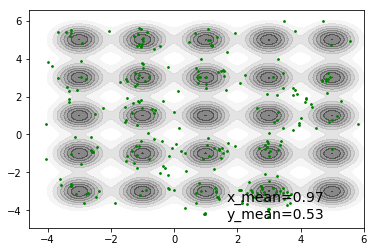

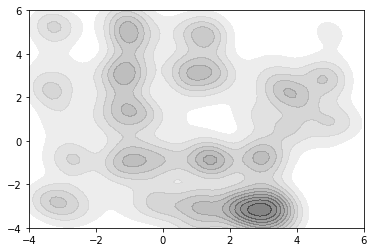

In [166]:

# closure, prob, plot_contours, plot_density = get_multimodal_fns(x, y, mixture=[1./25.]*25,
#                                                  means=[[2.*(i+1)-5., 2.*(j+1)-5.] for i in range(5) for j in range(5)],
#                                                  sigmas=[[0.5,0.5] for i in range(25)],
#                                                  corr = [0.]*25)


# closure, prob, plot_contours, plot_density = get_gauss_fns(x, y, 3.,0.3,.7)

n = 5
closure, prob, plot_contours, plot_density = get_multimodal_fns(x, y, mixture=[1./(n**2)]*(n**2),
                                                 means=[[2.*(i+1)-n, 2.*(j+1)-n] for i in range(n) for j in range(n)],
                                                 sigmas=[[0.5,0.5] for i in range(n**2)],
                                                 corr = [0.]*(n**2))


fig,ax=plt.subplots()
plot_contours(ax)
x_, y_ = [], []
chain = sampler.samples
for i, (sample, acc) in enumerate(chain[0*len(chain)//9:11*len(chain)//11]):
    if sample[0][1] is not None:
        x, y = sample[0][0][0], sample[0][1][0]
        x_.append(x)
        y_.append(y)    
        if acc and i%100==0:
    #         print(sample)
    #         print(x, y)
            ax.scatter(x, y, color='g', s=3)

# printing means
x_mean = np.mean([sample[0][0][0] for sample, acc in chain[1*len(chain)//10:] if (acc and sample[0][0] is not None)])
y_mean = np.mean([sample[0][1][0] for sample, acc in chain[1*len(chain)//10:] if (acc and sample[0][1] is not None)]) 
ax.annotate('x_mean={:.02f}\ny_mean={:.02f}'.format(x_mean, y_mean),
            xy=(0.88, 0.03), xycoords='axes fraction', fontsize=14,
             textcoords='offset points',
            ha='right', va='bottom')
print('x_mean={}, y_mean={}'.format(x_mean, y_mean))
print("last sample: ", chain[-1][0])

fig, ax = plt.subplots()
plot_density(ax, x_, y_)


accept rate: 1.0


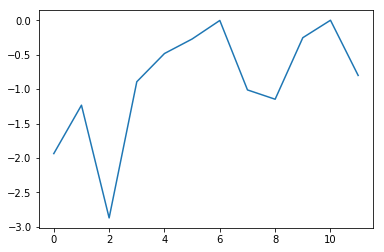

In [67]:
plt.plot(logp_array[::100])
print('accept rate:', len([1 for _, acc in chain[:] if acc])/len(chain))